In [166]:
import os
from sklearn.metrics import log_loss
import numpy as np
import pandas as pd
from sklearn import preprocessing
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import random,math
seed = 10
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
import eli5

In [167]:
%%time
train_transaction = pd.read_csv('../input/train_transaction.csv', index_col='TransactionID')
test_transaction = pd.read_csv('../input/test_transaction.csv', index_col='TransactionID')

train_identity = pd.read_csv('../input/train_identity.csv', index_col='TransactionID')
test_identity = pd.read_csv('../input/test_identity.csv', index_col='TransactionID')

# train_pred = pd.read_csv('./simple_xgboost_cv.csv', index_col='TransactionID')
# test_pred = pd.read_csv('./simple_xgboost_pred.csv', index_col='TransactionID')
# test_pred['pred'] = (test_pred['pred1'] + test_pred['pred2'] + test_pred['pred3'] )/3
# del test_pred['pred1'],test_pred['pred2'],test_pred['pred3']

# train_f1 = pd.read_csv('../input/f1_train.csv', index_col='TransactionID')[["f148_amt_counts","f148_card1_counts"]]
# test_f1 = pd.read_csv('../input/f1_test.csv', index_col='TransactionID')[["f148_amt_counts","f148_card1_counts"]]



sample_submission = pd.read_csv('../input/sample_submission.csv', index_col='TransactionID')

CPU times: user 45.7 s, sys: 3.86 s, total: 49.5 s
Wall time: 49.5 s


In [168]:
train_f5 = pd.read_csv('../input/fd_train3.csv', index_col='TransactionID')
test_f5 = pd.read_csv('../input/fd_test3.csv', index_col='TransactionID')
train_transaction = train_transaction.merge(train_f5, how='left', left_index=True, right_index=True)
test_transaction = test_transaction.merge(test_f5, how='left', left_index=True, right_index=True)

train_f5 = pd.read_csv('../input/fe_train2.csv', index_col='TransactionID')
test_f5 = pd.read_csv('../input/fe_test2.csv', index_col='TransactionID')
train_transaction = train_transaction.merge(train_f5, how='left', left_index=True, right_index=True)
test_transaction = test_transaction.merge(test_f5, how='left', left_index=True, right_index=True)



In [169]:


debug = True
if debug:
    train_f5 = pd.read_csv('../input/xgb_26_train_debug.csv', index_col='TransactionID')
    test_f5 = pd.read_csv('../input/xgb_26_test_debug.csv', index_col='TransactionID')
    train_transaction = train_transaction.merge(train_f5.append(test_f5), how='left', left_index=True, right_index=True)
    train_transaction['pred23'] = train_transaction['pred_1'] + train_transaction['pred_2'] + train_transaction['pred_3']
    del  train_transaction['pred_1'],train_transaction['pred_2'], train_transaction['pred_3']
    test_transaction['pred23'] = 0.5
    
else:
    train_f5 = pd.read_csv('../input/xgb_26_train.csv', index_col='TransactionID')
    test_f5 = pd.read_csv('../input/xgb_26_test.csv', index_col='TransactionID')
    train_transaction = train_transaction.merge(train_f5, how='left', left_index=True, right_index=True)
    test_transaction = test_transaction.merge(test_f5, how='left', left_index=True, right_index=True)  
    train_transaction['pred23'] = train_transaction['pred_1'] + train_transaction['pred_2'] + train_transaction['pred_3']
    del  train_transaction['pred_1'],train_transaction['pred_2'], train_transaction['pred_3']
    test_transaction['pred23'] = test_transaction['pred_1'] + test_transaction['pred_2'] + test_transaction['pred_3']
    del  test_transaction['pred_1'],test_transaction['pred_2'], test_transaction['pred_3']
    
# if debug:
#     train_f5 = pd.read_csv('../input/ff_train_debug.csv', index_col='TransactionID')
#     test_f5 = pd.read_csv('../input/ff_test_debug.csv', index_col='TransactionID')
#     train_transaction = train_transaction.merge(train_f5.append(test_f5), how='left', left_index=True, right_index=True)
#     for x in train_f5.columns.tolist():
#         test_transaction[x] = 0
#     col_del_oof = train_f5.columns
# else:
#     train_f5 = pd.read_csv('../input/xgb_26_train.csv', index_col='TransactionID')
#     test_f5 = pd.read_csv('../input/xgb_26_test.csv', index_col='TransactionID')
#     train_transaction = train_transaction.merge(train_f5, how='left', left_index=True, right_index=True)
#     test_transaction = test_transaction.merge(test_f5, how='left', left_index=True, right_index=True)  
#     col_del_oof = train_f5.columns

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [170]:
import pickle
print(train_transaction.shape)
print(test_transaction.shape)


(590540, 404)
(506691, 403)


In [171]:
train_transaction['TransactionDT2'] = train_transaction['TransactionDT'].map(lambda x:(x//(3600*24*7)))
test_transaction['TransactionDT2'] = test_transaction['TransactionDT'].map(lambda x:(x//(3600*24*7)))

f = open('emb/index_feature2.pkl','rb')
index_feature = pickle.loads(f.read())
feature_index = {}
for k,v in index_feature.items():
    feature_index[v] = k
    print(k,v)

embeddings_matrix = np.load("emb/spectral3.emb.npy")
print(embeddings_matrix.shape)
embeddings_dict = {}
for i in range((embeddings_matrix.shape[0])):
    embeddings_dict[feature_index[i]] = embeddings_matrix[i,:]

for col in "P_emaildomain".split(","):
    print(col)
    for i in range(24):
        train_transaction["w2v_"+col+"_"+str(i)] = train_transaction[col].fillna(-1).map(lambda x:embeddings_dict.get(col+"_"+str((x)),[0]*24)[i])
        test_transaction["w2v_"+col+"_"+str(i)] = test_transaction[col].fillna(-1).map(lambda x:embeddings_dict.get(col+"_"+str((x)),[0]*24)[i])       
        #         print(train_transaction["w2v_"+col+str(i)])         

for col in "card1,addr1".split(","):
    for i in range(24):
        train_transaction["w2v_"+col+"_"+str(i)] = train_transaction[col].fillna(-1).map(lambda x:embeddings_dict.get(col+"_"+str(int(x)),[0]*24)[i])
        test_transaction["w2v_"+col+"_"+str(i)] = test_transaction[col].fillna(-1).map(lambda x:embeddings_dict.get(col+"_"+str(int(x)),[0]*24)[i])



TransactionDT_0 0
TransactionDT2_0 1
card1_13926 2
addr1_315 3
P_emaildomain_-1 4
amt_68.5 5
card1_2755 6
addr1_325 7
P_emaildomain_gmail.com 8
amt_29.0 9
card1_4663 10
addr1_330 11
P_emaildomain_outlook.com 12
amt_59.0 13
card1_18132 14
addr1_476 15
P_emaildomain_yahoo.com 16
amt_50.0 17
card1_4497 18
addr1_420 19
card1_5937 20
addr1_272 21
amt_49.0 22
card1_12308 23
addr1_126 24
amt_159.0 25
card1_12695 26
P_emaildomain_mail.com 27
amt_422.5 28
card1_2803 29
addr1_337 30
P_emaildomain_anonymous.com 31
amt_15.0 32
card1_17399 33
addr1_204 34
amt_117.0 35
card1_16496 36
addr1_-1 37
amt_75.887 38
card1_4461 39
P_emaildomain_hotmail.com 40
amt_16.495 41
card1_3786 42
P_emaildomain_verizon.net 43
card1_12866 44
P_emaildomain_aol.com 45
amt_40.0 46
card1_11839 47
addr1_226 48
amt_10.5 49
card1_7055 50
amt_57.95 51
card1_1790 52
addr1_170 53
amt_30.0 54
card1_11492 55
amt_100.0 56
addr1_184 57
amt_47.95 58
card1_7005 59
addr1_264 60
amt_186.0 61
card1_7875 62
addr1_299 63
amt_39.0 64
card1_

amt_63.97 953
card1_12694 954
amt_85.0 955
card1_2804 956
amt_405.0 957
card1_3917 958
card1_2157 959
amt_1420.0 960
card1_6806 961
amt_115.0 962
amt_124.0 963
card1_12725 964
card1_7900 965
card1_11794 966
card1_2114 967
card1_3310 968
amt_57.0 969
card1_3331 970
amt_108.43 971
card1_16435 972
amt_28.95 973
card1_10838 974
card1_12556 975
amt_224.0 976
amt_574.95 977
card1_13018 978
amt_152.0 979
card1_1191 980
card1_14084 981
card1_11664 982
card1_1874 983
amt_28.76 984
card1_8436 985
card1_3166 986
card1_11849 987
card1_3524 988
card1_12291 989
card1_17064 990
amt_275.99 991
amt_38.548 992
card1_4975 993
card1_7468 994
amt_542.0 995
card1_10107 996
card1_10948 997
card1_15359 998
amt_243.0 999
card1_14540 1000
card1_2263 1001
card1_12747 1002
card1_6908 1003
card1_8356 1004
amt_552.0 1005
card1_17755 1006
amt_167.0 1007
card1_12615 1008
card1_9936 1009
card1_2773 1010
amt_97.95 1011
amt_156.99 1012
card1_10856 1013
card1_16485 1014
card1_13052 1015
amt_221.99 1016
card1_8439 1017
ca

card1_14681 2102
card1_14205 2103
card1_12351 2104
amt_26.886999999999997 2105
card1_7363 2106
amt_88.5 2107
amt_46.765 2108
amt_332.39 2109
amt_128.5 2110
card1_5958 2111
amt_1242.1 2112
amt_32.0 2113
amt_62.111999999999995 2114
amt_244.95 2115
amt_112.66 2116
card1_9350 2117
amt_12.99 2118
card1_5789 2119
amt_22.5 2120
card1_14318 2121
card1_5147 2122
card1_6507 2123
card1_12104 2124
card1_10756 2125
amt_304.7 2126
amt_205.0 2127
card1_17517 2128
card1_8058 2129
amt_7.19 2130
card1_3324 2131
amt_17.522000000000002 2132
amt_362.95 2133
amt_46.99 2134
amt_28.941 2135
card1_3916 2136
card1_4717 2137
card1_1506 2138
card1_5761 2139
amt_23.25 2140
card1_7757 2141
amt_233.0 2142
amt_29.061999999999998 2143
card1_17208 2144
amt_484.95 2145
card1_13120 2146
amt_183.45 2147
amt_71.65 2148
amt_21.147 2149
card1_11942 2150
amt_32.023 2151
card1_12690 2152
card1_12783 2153
card1_10505 2154
amt_118.02 2155
card1_4476 2156
card1_7170 2157
card1_13073 2158
amt_639.0 2159
addr1_491 2160
card1_1738 2

card1_8954 3449
card1_13295 3450
card1_5906 3451
card1_16868 3452
card1_12296 3453
card1_17000 3454
amt_30.451999999999998 3455
amt_42.052 3456
amt_93.772 3457
card1_6544 3458
amt_21.872 3459
card1_1595 3460
card1_14011 3461
amt_32.5 3462
amt_109.51 3463
card1_7389 3464
amt_97.45700000000001 3465
amt_46.161 3466
amt_29.364 3467
amt_29.171 3468
amt_429.0 3469
amt_8.217 3470
card1_16498 3471
amt_210.987 3472
card1_7653 3473
card1_11602 3474
amt_13.315 3475
amt_33.412 3476
amt_511.39 3477
amt_22.355 3478
card1_12145 3479
card1_13979 3480
amt_130.991 3481
card1_5741 3482
amt_79.47 3483
amt_59.36 3484
card1_1528 3485
card1_10051 3486
card1_1183 3487
card1_7950 3488
amt_18.972 3489
amt_55.99 3490
card1_9168 3491
amt_102.714 3492
amt_804.95 3493
card1_9635 3494
amt_42.657 3495
card1_9816 3496
card1_4303 3497
card1_16794 3498
card1_1281 3499
amt_25.135 3500
amt_43.14 3501
card1_11776 3502
amt_26.343000000000004 3503
amt_39.454 3504
amt_59.31 3505
card1_2678 3506
card1_18346 3507
amt_94.0 3508


amt_189.96 4537
card1_7592 4538
amt_493.95 4539
card1_5026 4540
card1_5014 4541
amt_344.05 4542
amt_85.555 4543
amt_254.95 4544
card1_13241 4545
card1_6372 4546
amt_8.398 4547
amt_302.46 4548
card1_6782 4549
card1_1075 4550
card1_14916 4551
card1_15856 4552
amt_1524.75 4553
amt_129.5 4554
card1_7643 4555
amt_345.39 4556
card1_1083 4557
amt_34.379 4558
amt_24.954 4559
amt_1511.28 4560
amt_43.925 4561
amt_33.714 4562
card1_2689 4563
card1_12107 4564
amt_72.92699999999999 4565
card1_1175 4566
card1_8972 4567
card1_13374 4568
card1_11538 4569
card1_9711 4570
card1_4096 4571
card1_3335 4572
amt_600.28 4573
card1_17681 4574
card1_14058 4575
amt_1257.67 4576
card1_11661 4577
card1_6521 4578
card1_17667 4579
card1_10366 4580
addr1_296 4581
card1_2936 4582
amt_464.95 4583
card1_3673 4584
card1_4859 4585
amt_406.47 4586
card1_1993 4587
amt_1152.95 4588
amt_118.0 4589
card1_4125 4590
amt_5.74 4591
amt_28.337 4592
amt_350.47 4593
card1_14795 4594
amt_48.92 4595
card1_2471 4596
amt_29.787 4597
amt_

card1_2337 5942
card1_14152 5943
card1_1364 5944
card1_9186 5945
amt_105.735 5946
addr1_359 5947
card1_11274 5948
amt_9.387 5949
card1_4901 5950
card1_6065 5951
card1_10480 5952
card1_11755 5953
card1_13919 5954
amt_70.443 5955
card1_4672 5956
amt_125.14 5957
amt_193.94799999999998 5958
card1_10567 5959
amt_398.9 5960
card1_4111 5961
amt_443.95 5962
card1_6439 5963
card1_15630 5964
card1_3422 5965
card1_3058 5966
amt_609.99 5967
amt_18.368 5968
amt_117.85 5969
amt_676.47 5970
amt_72.50399999999999 5971
card1_17726 5972
amt_475.95 5973
amt_1203.1 5974
amt_524.88 5975
card1_10145 5976
amt_419.26 5977
amt_32.981 5978
amt_339.14 5979
amt_33.5 5980
amt_33.291 5981
card1_2643 5982
amt_788.95 5983
card1_3608 5984
amt_167.605 5985
card1_15176 5986
card1_10303 5987
card1_6137 5988
amt_30.331 5989
card1_8075 5990
card1_15604 5991
card1_7663 5992
card1_17327 5993
card1_13139 5994
card1_13140 5995
card1_3858 5996
addr1_499 5997
card1_14265 5998
card1_4650 5999
card1_3070 6000
card1_12419 6001
amt_

card1_17999 7288
amt_41.393 7289
card1_10350 7290
card1_17027 7291
amt_499.99 7292
card1_5819 7293
card1_10177 7294
amt_191.0 7295
addr1_213 7296
amt_290.5 7297
card1_2587 7298
amt_21.105 7299
amt_654.86 7300
card1_8599 7301
amt_1068.65 7302
card1_9853 7303
amt_472.0 7304
amt_224.05 7305
card1_8082 7306
addr1_514 7307
amt_8.687000000000001 7308
amt_576.65 7309
amt_2589.29 7310
card1_5641 7311
amt_76.023 7312
amt_10.261 7313
card1_4642 7314
card1_8776 7315
amt_454.32 7316
amt_256.5 7317
amt_101.675 7318
card1_11793 7319
card1_12587 7320
amt_62.964 7321
amt_255.354 7322
card1_3366 7323
card1_1837 7324
amt_50.838 7325
amt_170.024 7326
card1_9099 7327
card1_5427 7328
amt_1097.52 7329
amt_134.55700000000002 7330
card1_13200 7331
amt_16.324 7332
card1_6281 7333
amt_50.75 7334
card1_6910 7335
card1_17825 7336
amt_19.705 7337
card1_6068 7338
amt_1119.76 7339
amt_64.0 7340
amt_225.83 7341
amt_573.0 7342
amt_11.31 7343
card1_14306 7344
card1_4231 7345
card1_5424 7346
amt_1223.99 7347
card1_14408

amt_465.5 8800
card1_8176 8801
amt_2053.51 8802
amt_2853.97 8803
card1_15439 8804
card1_15969 8805
card1_8690 8806
card1_11121 8807
card1_15290 8808
addr1_406 8809
card1_7764 8810
card1_10222 8811
amt_387.45 8812
card1_6606 8813
amt_51.129 8814
amt_870.71 8815
card1_2611 8816
card1_8812 8817
card1_18052 8818
amt_7.579 8819
card1_2682 8820
card1_13521 8821
addr1_467 8822
amt_66.229 8823
card1_8834 8824
card1_5941 8825
amt_411.35 8826
amt_49.63 8827
card1_9224 8828
addr1_117 8829
amt_64.872 8830
card1_10764 8831
card1_3844 8832
card1_3249 8833
amt_247.775 8834
amt_2120.94 8835
card1_1625 8836
amt_38.42 8837
card1_9632 8838
card1_18046 8839
card1_5171 8840
amt_348.71 8841
card1_3180 8842
card1_13342 8843
amt_334.93 8844
card1_18154 8845
card1_11847 8846
amt_77.189 8847
card1_17297 8848
card1_11111 8849
card1_3511 8850
amt_185.27700000000002 8851
card1_17232 8852
amt_393.0 8853
card1_12811 8854
amt_23.145 8855
amt_344.17 8856
card1_17855 8857
amt_333.94 8858
amt_747.95 8859
amt_1363.34 886

amt_29.325 10168
card1_4936 10169
amt_2887.2 10170
addr1_168 10171
card1_4011 10172
amt_61.565 10173
amt_114.735 10174
card1_10037 10175
card1_17794 10176
amt_962.35 10177
amt_1748.52 10178
amt_17.665 10179
amt_195.2 10180
amt_166.855 10181
amt_753.95 10182
card1_10752 10183
card1_1485 10184
card1_15797 10185
addr1_297 10186
card1_5605 10187
amt_16.383 10188
amt_792.0 10189
card1_6206 10190
amt_21.574 10191
amt_24.804000000000002 10192
card1_17965 10193
amt_54.102 10194
amt_79.113 10195
card1_11898 10196
amt_88.55799999999999 10197
card1_9234 10198
card1_7424 10199
amt_64.36399999999999 10200
amt_129.659 10201
amt_1998.97 10202
amt_263.85 10203
amt_631.09 10204
card1_14621 10205
amt_109.13799999999999 10206
amt_278.14 10207
amt_430.49 10208
amt_724.54 10209
card1_15985 10210
amt_28.49 10211
amt_1629.95 10212
amt_37.365 10213
amt_75.79 10214
amt_246.36 10215
card1_11576 10216
amt_90.948 10217
amt_395.94 10218
card1_10435 10219
amt_118.46600000000001 10220
amt_1958.99 10221
card1_6262 10

amt_303.0 11279
amt_384.64 11280
card1_4500 11281
amt_168.429 11282
card1_1481 11283
amt_2057.0 11284
card1_4900 11285
card1_13058 11286
card1_10795 11287
card1_11751 11288
card1_14305 11289
amt_17.84 11290
amt_35.097 11291
amt_49.97 11292
card1_16679 11293
card1_8688 11294
card1_8875 11295
card1_16451 11296
amt_302.7 11297
card1_5011 11298
amt_1462.95 11299
amt_37.97 11300
card1_1098 11301
amt_140.41 11302
amt_81.5 11303
card1_5535 11304
card1_12920 11305
amt_816.18 11306
card1_9799 11307
card1_10021 11308
card1_3669 11309
amt_48.548 11310
card1_10691 11311
amt_130.55 11312
amt_751.24 11313
card1_14492 11314
amt_61.798 11315
amt_19.769000000000002 11316
amt_110.12899999999999 11317
card1_9023 11318
card1_14175 11319
card1_10361 11320
card1_13472 11321
amt_14.522 11322
amt_788.86 11323
amt_96.77799999999999 11324
card1_16855 11325
amt_157.0 11326
amt_14.204 11327
amt_492.95 11328
card1_16606 11329
amt_970.4 11330
amt_66.87 11331
amt_51.596000000000004 11332
amt_21.73 11333
card1_6768 1

card1_15580 12313
amt_575.0 12314
card1_4907 12315
card1_8540 12316
amt_39.623000000000005 12317
amt_337.292 12318
amt_47.94 12319
amt_182.82 12320
amt_3848.32 12321
card1_14109 12322
card1_2304 12323
amt_34.09 12324
card1_8746 12325
amt_662.84 12326
amt_450.6 12327
card1_12402 12328
card1_6272 12329
card1_10881 12330
amt_1147.53 12331
card1_1520 12332
card1_2557 12333
amt_303.14 12334
amt_615.78 12335
card1_7686 12336
amt_34.13 12337
amt_25.017 12338
amt_202.0 12339
card1_10487 12340
card1_4222 12341
amt_461.83 12342
amt_2369.95 12343
amt_1958.54 12344
card1_14343 12345
amt_59.523999999999994 12346
card1_6201 12347
card1_9516 12348
amt_154.76 12349
card1_3694 12350
amt_244.56 12351
card1_14718 12352
amt_91.0 12353
card1_2556 12354
amt_306.48 12355
amt_733.15 12356
card1_13471 12357
amt_571.15 12358
card1_2180 12359
amt_97.07 12360
amt_316.77 12361
amt_207.023 12362
card1_15575 12363
card1_15210 12364
amt_15.317 12365
amt_253.0 12366
card1_3262 12367
card1_3893 12368
amt_821.48 12369
a

amt_84.164 13751
amt_136.21 13752
card1_14864 13753
amt_262.57 13754
amt_817.06 13755
card1_14315 13756
card1_6037 13757
card1_2883 13758
card1_12728 13759
card1_6223 13760
amt_212.795 13761
card1_8047 13762
card1_1043 13763
amt_721.45 13764
card1_1029 13765
card1_17521 13766
amt_75.09 13767
amt_115.02600000000001 13768
amt_1541.0 13769
amt_159.48 13770
amt_789.0 13771
amt_83.13600000000001 13772
card1_7176 13773
amt_355.44 13774
amt_31.058000000000003 13775
card1_15473 13776
amt_61.48 13777
card1_9388 13778
amt_148.0 13779
card1_14236 13780
card1_16574 13781
amt_46.815 13782
amt_449.99 13783
card1_8572 13784
amt_148.548 13785
card1_4906 13786
amt_356.26 13787
card1_5238 13788
card1_5038 13789
amt_27.454 13790
card1_6112 13791
amt_799.0 13792
card1_12340 13793
amt_276.1 13794
card1_17636 13795
amt_260.95 13796
card1_16856 13797
card1_15248 13798
amt_461.49 13799
card1_10542 13800
amt_1236.95 13801
amt_168.25400000000002 13802
card1_5568 13803
card1_10288 13804
amt_736.95 13805
card1_92

amt_1580.0 15231
amt_273.25 15232
amt_392.05 15233
card1_9719 15234
amt_154.145 15235
amt_455.0 15236
amt_2132.31 15237
card1_10913 15238
card1_5307 15239
card1_7117 15240
card1_8995 15241
card1_4474 15242
amt_782.95 15243
card1_15138 15244
amt_471.59 15245
amt_102.77 15246
amt_395.95 15247
card1_1331 15248
amt_44.86 15249
amt_357.8 15250
card1_17414 15251
amt_83.573 15252
card1_2197 15253
card1_10213 15254
card1_5054 15255
amt_135.373 15256
card1_16167 15257
card1_5582 15258
amt_424.17 15259
amt_337.0 15260
card1_3498 15261
amt_558.55 15262
card1_4385 15263
card1_16696 15264
card1_3976 15265
amt_94.679 15266
amt_569.45 15267
amt_631.95 15268
amt_929.0 15269
amt_66.171 15270
amt_110.304 15271
amt_1500.75 15272
amt_83.01899999999999 15273
amt_805.95 15274
amt_18.598 15275
amt_1787.39 15276
amt_98.41 15277
amt_317.02 15278
amt_368.99 15279
card1_6285 15280
amt_2041.81 15281
amt_219.208 15282
amt_456.95 15283
amt_625.95 15284
card1_9161 15285
amt_547.47 15286
card1_13503 15287
amt_548.95 

amt_442.8 16502
amt_399.03 16503
amt_281.0 16504
amt_19.414 16505
amt_1342.68 16506
card1_12129 16507
amt_964.0 16508
card1_2877 16509
card1_16986 16510
card1_8072 16511
amt_719.2 16512
card1_17322 16513
card1_2119 16514
amt_399.74 16515
card1_11292 16516
amt_865.0 16517
amt_87.275 16518
card1_14389 16519
card1_11648 16520
card1_6577 16521
card1_7581 16522
amt_1103.99 16523
amt_852.47 16524
amt_18.253 16525
card1_15970 16526
amt_42.38399999999999 16527
amt_85.52600000000001 16528
card1_11034 16529
amt_43.937 16530
card1_15976 16531
amt_247.0 16532
card1_3896 16533
amt_37.49 16534
amt_27.49 16535
card1_10529 16536
card1_7918 16537
amt_200.3 16538
card1_6670 16539
card1_6243 16540
amt_710.47 16541
amt_769.57 16542
card1_14419 16543
card1_7948 16544
card1_3830 16545
card1_13378 16546
amt_15.25 16547
card1_10078 16548
card1_14837 16549
amt_483.95 16550
amt_43.99 16551
amt_813.55 16552
amt_374.45 16553
amt_2005.41 16554
card1_14872 16555
card1_12612 16556
amt_1905.61 16557
amt_655.92 16558


amt_563.45 17910
amt_1270.27 17911
amt_519.87 17912
amt_369.61 17913
card1_11387 17914
card1_17219 17915
card1_4629 17916
card1_4479 17917
amt_23.628 17918
card1_10571 17919
amt_162.34 17920
amt_249.12 17921
card1_9638 17922
amt_9.607000000000001 17923
amt_37.5 17924
amt_15.764000000000001 17925
amt_27.129 17926
amt_492.69 17927
amt_2166.95 17928
card1_11248 17929
amt_26.805999999999997 17930
amt_359.0 17931
amt_14.558 17932
card1_14860 17933
amt_20.739 17934
card1_4390 17935
amt_844.2 17936
card1_12016 17937
amt_732.98 17938
amt_1226.62 17939
amt_610.95 17940
amt_130.447 17941
card1_1237 17942
amt_584.73 17943
amt_1816.03 17944
amt_511.74 17945
amt_1698.37 17946
card1_17690 17947
amt_71.054 17948
amt_89.47 17949
amt_299.88 17950
amt_237.0 17951
amt_423.18 17952
card1_10753 17953
amt_563.08 17954
amt_80.45 17955
amt_168.688 17956
card1_8822 17957
amt_557.95 17958
amt_258.0 17959
card1_12398 17960
amt_17.824 17961
amt_23.339000000000002 17962
amt_14.561 17963
amt_208.73 17964
amt_111.89

amt_311.94 19229
amt_787.95 19230
card1_3396 19231
amt_68.27 19232
amt_49.236999999999995 19233
card1_10169 19234
amt_784.84 19235
card1_15077 19236
amt_1754.67 19237
card1_1016 19238
amt_322.25 19239
card1_9384 19240
card1_9908 19241
amt_47.5 19242
amt_1355.98 19243
addr1_463 19244
amt_328.95 19245
card1_15311 19246
card1_17504 19247
card1_14154 19248
card1_11273 19249
card1_17878 19250
amt_81.678 19251
card1_13587 19252
amt_2265.95 19253
amt_2700.95 19254
amt_470.99 19255
card1_15033 19256
card1_3877 19257
amt_678.28 19258
amt_596.0 19259
amt_882.95 19260
amt_500.2 19261
card1_13970 19262
card1_3482 19263
amt_460.8 19264
amt_1794.81 19265
card1_18012 19266
card1_7248 19267
amt_134.47 19268
amt_272.34 19269
amt_708.5 19270
amt_642.99 19271
amt_237.67 19272
card1_15061 19273
amt_312.33 19274
amt_425.67 19275
card1_14974 19276
card1_11355 19277
amt_200.77 19278
card1_15151 19279
amt_8.318 19280
amt_509.14 19281
amt_496.66 19282
card1_5945 19283
amt_749.19 19284
card1_2450 19285
amt_14.4

card1_1973 20726
amt_6.343999999999999 20727
card1_3308 20728
amt_19.733 20729
amt_2125.95 20730
amt_348.36 20731
card1_3185 20732
amt_676.24 20733
amt_323.5 20734
amt_1614.95 20735
card1_1582 20736
amt_20.845 20737
amt_860.59 20738
amt_504.8 20739
amt_580.95 20740
amt_605.9 20741
card1_9707 20742
card1_13981 20743
amt_281.36 20744
amt_278.86 20745
amt_122.773 20746
amt_276.86 20747
amt_742.95 20748
amt_132.32 20749
amt_580.04 20750
card1_15481 20751
amt_18.247 20752
amt_10.694 20753
amt_7.855 20754
amt_41.931000000000004 20755
card1_15203 20756
amt_473.67 20757
amt_39.696 20758
card1_4052 20759
amt_83.98 20760
card1_6067 20761
amt_32.083 20762
amt_161.442 20763
amt_82.111 20764
amt_51.538000000000004 20765
amt_10.270999999999999 20766
amt_30.875 20767
amt_232.919 20768
card1_1583 20769
amt_11.842 20770
amt_15.045 20771
amt_332.48 20772
card1_14798 20773
amt_85.132 20774
card1_1958 20775
amt_373.7 20776
amt_459.85 20777
amt_52.68600000000001 20778
amt_47.49 20779
card1_3483 20780
amt_4

amt_210.94 21953
amt_71.5 21954
amt_67.9 21955
card1_6443 21956
amt_38.246 21957
card1_11501 21958
amt_1967.6 21959
amt_222.63 21960
amt_369.93 21961
amt_64.227 21962
amt_381.69 21963
card1_3322 21964
amt_357.45 21965
amt_9.849 21966
amt_546.67 21967
amt_117.366 21968
amt_28.11 21969
amt_54.43899999999999 21970
amt_927.0 21971
amt_1269.69 21972
card1_11472 21973
amt_864.0 21974
amt_555.23 21975
amt_24.138 21976
amt_386.91 21977
amt_447.74 21978
addr1_381 21979
amt_282.1 21980
amt_98.99 21981
amt_2925.47 21982
card1_17546 21983
amt_163.376 21984
amt_85.01100000000001 21985
amt_631.2 21986
card1_6633 21987
amt_414.79 21988
amt_601.95 21989
amt_29.985 21990
addr1_340 21991
amt_320.99 21992
card1_3469 21993
card1_1787 21994
addr1_369 21995
amt_172.05 21996
card1_7725 21997
amt_244.52 21998
card1_8614 21999
amt_368.14 22000
card1_11287 22001
amt_450.66 22002
card1_10417 22003
amt_1435.88 22004
amt_594.64 22005
card1_15714 22006
amt_912.47 22007
amt_261.38 22008
amt_496.95 22009
amt_163.6170

card1_7523 23413
amt_950.3 23414
amt_26.21 23415
amt_976.95 23416
amt_336.56 23417
amt_547.0 23418
amt_410.89 23419
card1_16961 23420
amt_22.415 23421
card1_9235 23422
amt_106.99 23423
amt_41.653 23424
amt_109.723 23425
amt_398.99 23426
amt_898.95 23427
card1_6154 23428
card1_3634 23429
amt_1197.47 23430
amt_398.87 23431
amt_4199.55 23432
amt_132.924 23433
card1_13440 23434
card1_11522 23435
amt_657.49 23436
amt_732.09 23437
card1_11672 23438
amt_1439.82 23439
amt_82.95700000000001 23440
card1_15523 23441
amt_2208.53 23442
card1_18111 23443
card1_11548 23444
amt_740.32 23445
amt_58.45 23446
amt_45.556999999999995 23447
card1_6658 23448
card1_4924 23449
card1_12821 23450
amt_1131.13 23451
card1_17784 23452
amt_1640.95 23453
amt_305.64 23454
card1_7524 23455
card1_14311 23456
amt_383.78 23457
card1_3155 23458
amt_197.95 23459
amt_502.95 23460
amt_507.45 23461
amt_1395.26 23462
amt_389.27 23463
card1_8921 23464
card1_2440 23465
amt_376.79 23466
card1_15440 23467
amt_2450.91 23468
amt_31.6

amt_16.695 24287
card1_16302 24288
amt_4026.97 24289
card1_10873 24290
amt_80.54 24291
amt_800.14 24292
amt_638.22 24293
card1_3256 24294
amt_3.747 24295
amt_354.93 24296
amt_253.8 24297
amt_7.432 24298
amt_2.477 24299
amt_1332.21 24300
amt_40.959 24301
amt_69.362 24302
amt_74.196 24303
amt_513.87 24304
amt_90.02600000000001 24305
card1_7982 24306
amt_2847.0 24307
amt_16.637999999999998 24308
amt_89.65899999999999 24309
amt_39.358000000000004 24310
amt_1112.99 24311
amt_86.038 24312
amt_2753.95 24313
amt_46.909 24314
card1_12947 24315
amt_1211.95 24316
amt_1999.95 24317
amt_98.243 24318
amt_60.5 24319
amt_104.78 24320
amt_1876.87 24321
amt_745.95 24322
amt_25.7 24323
amt_294.02 24324
amt_346.09 24325
amt_1969.63 24326
amt_711.95 24327
amt_2053.19 24328
amt_427.5 24329
amt_377.95 24330
amt_602.61 24331
amt_945.17 24332
amt_719.95 24333
amt_472.65 24334
card1_13246 24335
amt_1675.95 24336
card1_15229 24337
amt_1560.95 24338
card1_3195 24339
card1_16891 24340
card1_13104 24341
amt_294.89 

amt_3975.79 25486
card1_5218 25487
amt_423.77 25488
amt_1280.75 25489
addr1_166 25490
amt_509.5 25491
card1_7754 25492
amt_2402.86 25493
amt_2983.95 25494
card1_17278 25495
amt_150.47 25496
amt_512.71 25497
card1_13065 25498
amt_618.04 25499
amt_3201.95 25500
amt_128.393 25501
amt_185.47 25502
amt_3929.51 25503
amt_90.811 25504
amt_749.73 25505
amt_121.08200000000001 25506
amt_459.6 25507
amt_893.03 25508
amt_334.5 25509
amt_642.44 25510
amt_1474.5 25511
card1_15670 25512
amt_896.35 25513
amt_1091.0 25514
card1_15723 25515
amt_305.81 25516
amt_362.91 25517
amt_125.476 25518
amt_357.73 25519
card1_6605 25520
amt_1980.5 25521
amt_702.0 25522
amt_1482.28 25523
amt_768.88 25524
card1_12417 25525
amt_19.45 25526
amt_395.79 25527
amt_375.91 25528
card1_11655 25529
amt_18.85 25530
amt_1310.66 25531
amt_1504.25 25532
amt_796.0 25533
amt_1260.5 25534
amt_1075.25 25535
card1_11324 25536
amt_216.5 25537
amt_2455.1 25538
amt_86.884 25539
amt_38.57 25540
amt_57.913000000000004 25541
amt_161.201 255

amt_2395.64 26740
amt_1169.2 26741
card1_12999 26742
amt_484.94 26743
amt_731.95 26744
amt_8.047 26745
amt_1240.09 26746
card1_18315 26747
amt_709.47 26748
amt_520.49 26749
card1_11177 26750
amt_31.088 26751
amt_196.282 26752
card1_16403 26753
amt_194.40900000000002 26754
amt_315.4 26755
amt_2877.95 26756
card1_14425 26757
card1_11577 26758
amt_1194.95 26759
amt_715.0 26760
amt_297.84 26761
card1_14723 26762
amt_643.79 26763
card1_13103 26764
amt_98.545 26765
amt_52.254 26766
amt_362.67 26767
amt_24.914 26768
amt_623.5 26769
amt_900.48 26770
amt_816.0 26771
amt_372.63 26772
amt_372.53 26773
amt_413.9 26774
amt_1013.27 26775
amt_172.016 26776
amt_111.316 26777
amt_72.051 26778
card1_2899 26779
amt_64.49 26780
amt_257.5 26781
card1_16257 26782
amt_273.33 26783
card1_17388 26784
amt_2023.26 26785
card1_9347 26786
amt_438.1 26787
card1_9075 26788
amt_375.15 26789
addr1_279 26790
amt_578.0 26791
amt_82.292 26792
amt_11.465 26793
card1_16371 26794
amt_3339.06 26795
amt_182.227 26796
amt_218.

card1_13267 27797
amt_0.861 27798
card1_14794 27799
amt_1288.66 27800
amt_2170.84 27801
amt_19.237000000000002 27802
amt_922.0 27803
amt_30.096 27804
amt_21.35 27805
amt_36.94 27806
amt_316.18 27807
amt_384.34 27808
amt_3074.81 27809
card1_2347 27810
amt_2609.66 27811
amt_338.1 27812
amt_96.31 27813
card1_12833 27814
amt_2168.32 27815
amt_689.1 27816
amt_76.507 27817
amt_471.28 27818
amt_351.0 27819
card1_6756 27820
amt_127.184 27821
amt_659.32 27822
card1_16021 27823
card1_15740 27824
amt_410.25 27825
amt_90.287 27826
card1_14895 27827
amt_728.95 27828
amt_14.79 27829
amt_470.18 27830
amt_635.25 27831
amt_239.505 27832
amt_14.882 27833
amt_472.8 27834
amt_236.65 27835
amt_232.68 27836
card1_1010 27837
amt_277.932 27838
amt_2792.95 27839
amt_246.58 27840
amt_418.75 27841
amt_2350.81 27842
amt_1415.1 27843
amt_100.90100000000001 27844
amt_47.42 27845
amt_257.6 27846
amt_288.21 27847
card1_15424 27848
amt_342.35 27849
card1_17079 27850
card1_12993 27851
amt_30.3 27852
amt_34.836 27853
ca

amt_42.852 29236
amt_10.38 29237
amt_30.864 29238
amt_107.959 29239
amt_1274.81 29240
amt_330.37 29241
amt_2396.47 29242
amt_17.153 29243
amt_35.056 29244
amt_793.0 29245
amt_277.19 29246
amt_29.264 29247
amt_120.501 29248
amt_751.0 29249
amt_93.204 29250
amt_548.13 29251
amt_18.382 29252
amt_18.26 29253
amt_48.385 29254
amt_62.156000000000006 29255
amt_12.296 29256
amt_33.015 29257
amt_55.332 29258
amt_29.142 29259
amt_53.027 29260
amt_212.106 29261
amt_20.719 29262
card1_14157 29263
card1_4352 29264
amt_17.214000000000002 29265
amt_34.306 29266
amt_32.707 29267
amt_12.357999999999999 29268
amt_75.374 29269
card1_9907 29270
amt_57.16 29271
amt_9.714 29272
amt_12.665 29273
card1_5025 29274
card1_13791 29275
amt_153.946 29276
amt_477.91 29277
amt_41.806000000000004 29278
amt_7.825 29279
amt_45.248999999999995 29280
amt_51.397 29281
card1_2738 29282
card1_2681 29283
amt_174.607 29284
amt_141.404 29285
amt_32.339 29286
amt_92.835 29287
card1_8268 29288
amt_45.74100000000001 29289
amt_85.7

card1_9601 30549
amt_33.260999999999996 30550
amt_506.87 30551
amt_457.99 30552
amt_10.284 30553
card1_10959 30554
amt_472.53 30555
amt_904.0 30556
card1_11549 30557
amt_313.85 30558
amt_486.85 30559
card1_18287 30560
card1_4026 30561
amt_53.488 30562
amt_368.56 30563
amt_95.417 30564
amt_87.056 30565
amt_1768.1 30566
amt_471.64 30567
card1_16223 30568
amt_265.72 30569
amt_584.34 30570
amt_2016.1 30571
amt_4.303999999999999 30572
amt_2.459 30573
card1_3420 30574
amt_125.911 30575
card1_13594 30576
amt_1627.38 30577
amt_110.664 30578
card1_13216 30579
amt_395.62 30580
amt_56.193000000000005 30581
amt_84.228 30582
amt_105.831 30583
addr1_237 30584
amt_249.916 30585
amt_47.155 30586
card1_10163 30587
amt_595.33 30588
amt_1615.55 30589
amt_29.633000000000003 30590
amt_230.52 30591
amt_2903.7 30592
amt_64.124 30593
amt_1053.0 30594
amt_1497.41 30595
amt_83.859 30596
amt_31.444000000000003 30597
amt_1802.19 30598
amt_148.659 30599
card1_7087 30600
amt_82.691 30601
card1_11283 30602
amt_1803.

card1_2221 31539
card1_15918 31540
amt_1138.81 31541
amt_4041.08 31542
amt_106.37 31543
amt_13.064 31544
amt_100.83 31545
amt_246.89 31546
amt_1746.92 31547
amt_267.58 31548
amt_310.1 31549
amt_976.61 31550
card1_6838 31551
card1_17775 31552
amt_72.423 31553
amt_189.78900000000002 31554
amt_338.02 31555
amt_434.84 31556
amt_653.48 31557
amt_486.07 31558
amt_755.82 31559
amt_87.79299999999999 31560
amt_349.32 31561
card1_9933 31562
amt_559.02 31563
amt_2686.75 31564
amt_916.0 31565
amt_1508.95 31566
card1_1541 31567
amt_148.29 31568
card1_10841 31569
card1_14587 31570
amt_379.52 31571
card1_11928 31572
amt_159.77 31573
amt_88.285 31574
amt_79.309 31575
amt_93.32700000000001 31576
amt_96.708 31577
amt_44.512 31578
amt_27.272 31579
amt_917.0 31580
amt_682.32 31581
amt_1395.0 31582
amt_2938.33 31583
amt_53.733999999999995 31584
amt_182.55 31585
amt_332.4 31586
card1_8281 31587
amt_995.49 31588
amt_3477.95 31589
card1_14309 31590
amt_226.75 31591
amt_470.41 31592
amt_262.13 31593
amt_688.66

amt_160.34 32674
amt_224.04 32675
amt_923.86 32676
amt_290.14 32677
card1_6919 32678
amt_4.444 32679
amt_61.574 32680
amt_32.646 32681
amt_1117.37 32682
amt_609.19 32683
amt_293.97 32684
amt_6.209 32685
card1_6099 32686
amt_254.54 32687
card1_8447 32688
amt_112.693 32689
amt_39.551 32690
amt_78.915 32691
amt_47.191 32692
amt_62.894 32693
amt_166.918 32694
amt_524.09 32695
card1_9698 32696
card1_8570 32697
card1_3098 32698
amt_120.009 32699
amt_108.82 32700
amt_508.55 32701
amt_122.1 32702
amt_1868.61 32703
amt_1953.95 32704
amt_275.82 32705
amt_941.0 32706
amt_20.135 32707
amt_1846.83 32708
card1_4340 32709
amt_507.14 32710
card1_12432 32711
amt_468.27 32712
amt_2974.89 32713
amt_1521.1 32714
amt_394.26 32715
card1_13403 32716
amt_30.561999999999998 32717
amt_317.62 32718
card1_12961 32719
amt_181.12 32720
amt_60.373000000000005 32721
amt_246.47400000000002 32722
card1_16749 32723
card1_16497 32724
amt_24.219 32725
amt_79.494 32726
amt_1749.95 32727
amt_25.94 32728
amt_460.85 32729
amt

amt_361.12 33843
card1_2856 33844
card1_14867 33845
card1_7964 33846
amt_378.33 33847
amt_302.06 33848
card1_9148 33849
amt_453.15 33850
amt_54.607 33851
amt_38.794000000000004 33852
amt_51.951 33853
amt_363.75 33854
card1_6311 33855
amt_412.72 33856
amt_24.829 33857
amt_3048.99 33858
amt_3047.99 33859
amt_74.575 33860
amt_105.62299999999999 33861
amt_95.601 33862
amt_4.718 33863
amt_14.349 33864
amt_15.671 33865
card1_10823 33866
amt_148.04399999999998 33867
amt_94.5 33868
amt_230.673 33869
amt_75.497 33870
amt_2255.0 33871
amt_214.21 33872
amt_3866.7 33873
card1_12224 33874
amt_78.295 33875
amt_1867.61 33876
amt_1145.15 33877
amt_1562.07 33878
card1_5797 33879
card1_8151 33880
amt_162.861 33881
amt_364.28 33882
amt_384.84 33883
amt_1954.95 33884
amt_464.34 33885
amt_874.83 33886
card1_16448 33887
amt_3500.0 33888
amt_2479.95 33889
card1_6362 33890
amt_1331.99 33891
amt_3704.01 33892
amt_1894.03 33893
amt_579.64 33894
amt_2287.47 33895
amt_2539.88 33896
amt_295.99 33897
amt_2182.95 33

amt_405.62 35059
card1_13540 35060
amt_289.61 35061
amt_357.72 35062
card1_8271 35063
card1_8188 35064
amt_398.71 35065
card1_6160 35066
amt_2230.36 35067
amt_72.362 35068
amt_289.07 35069
amt_1303.47 35070
amt_298.45 35071
amt_1004.15 35072
amt_386.45 35073
amt_921.95 35074
card1_9385 35075
card1_11417 35076
card1_5410 35077
amt_1514.64 35078
card1_3016 35079
card1_18239 35080
amt_298.4 35081
amt_423.87 35082
amt_454.18 35083
card1_11263 35084
card1_8403 35085
card1_12227 35086
amt_234.0 35087
amt_250.92 35088
amt_306.5 35089
amt_84.351 35090
amt_1298.2 35091
amt_2147.95 35092
amt_43.84 35093
amt_52.688 35094
amt_325.77 35095
amt_155.298 35096
amt_374.72 35097
amt_124.927 35098
amt_203.25 35099
amt_400.13 35100
card1_1579 35101
card1_15825 35102
card1_2621 35103
amt_140.482 35104
card1_8417 35105
amt_739.49 35106
amt_1679.4 35107
amt_488.45 35108
amt_1684.2 35109
amt_185.62 35110
card1_1414 35111
amt_671.77 35112
amt_1368.77 35113
card1_9983 35114
card1_1165 35115
card1_12716 35116
ca

amt_1431.16 36278
card1_17954 36279
amt_30.393 36280
card1_13589 36281
amt_1077.47 36282
amt_454.01 36283
amt_58.55 36284
amt_15.773 36285
card1_17553 36286
card1_13093 36287
amt_14.56 36288
amt_108.943 36289
amt_14.600999999999999 36290
card1_13624 36291
amt_143.248 36292
amt_24.015 36293
amt_2871.35 36294
amt_945.77 36295
amt_2184.61 36296
amt_4182.95 36297
amt_889.9 36298
amt_546.99 36299
card1_4058 36300
amt_1547.95 36301
amt_2710.75 36302
card1_14821 36303
amt_12.62 36304
card1_16842 36305
amt_619.12 36306
amt_1164.07 36307
card1_14882 36308
amt_824.83 36309
amt_262.96 36310
amt_590.84 36311
card1_4697 36312
card1_9309 36313
amt_119.32600000000001 36314
amt_150.27200000000002 36315
card1_14436 36316
amt_2990.41 36317
amt_34.853 36318
card1_4428 36319
amt_104.559 36320
card1_16342 36321
amt_67.52199999999999 36322
amt_512.4 36323
amt_292.4 36324
amt_222.61900000000003 36325
card1_10982 36326
amt_245.94 36327
amt_2973.25 36328
amt_72.962 36329
amt_76.762 36330
amt_235.54 36331
card1

card1_8171 37682
amt_223.66400000000002 37683
card1_13566 37684
card1_4533 37685
card1_14385 37686
amt_289.7 37687
amt_727.18 37688
amt_1635.33 37689
amt_610.89 37690
amt_445.25 37691
card1_11463 37692
card1_12448 37693
amt_567.2 37694
card1_10860 37695
amt_577.48 37696
amt_434.64 37697
amt_191.264 37698
card1_3545 37699
amt_139.805 37700
amt_86.46 37701
card1_7019 37702
amt_760.37 37703
amt_148.597 37704
amt_0.258 37705
amt_257.355 37706
card1_7512 37707
amt_416.5 37708
amt_813.8 37709
amt_25.84 37710
card1_13945 37711
card1_14656 37712
card1_15031 37713
amt_577.75 37714
amt_422.37 37715
amt_998.67 37716
amt_446.17 37717
amt_941.19 37718
card1_15208 37719
amt_1869.2 37720
amt_557.55 37721
amt_1068.69 37722
card1_16710 37723
amt_559.86 37724
amt_429.47 37725
amt_2700.24 37726
amt_810.95 37727
amt_928.99 37728
amt_2475.17 37729
amt_679.77 37730
amt_113.24700000000001 37731
amt_57.183 37732
amt_2535.53 37733
amt_842.03 37734
amt_185.72 37735
card1_12036 37736
amt_471.07 37737
amt_574.73 

amt_2685.27 38774
amt_69.657 38775
amt_923.95 38776
amt_524.94 38777
card1_7475 38778
amt_123.012 38779
amt_118.75399999999999 38780
amt_1191.59 38781
amt_609.43 38782
amt_360.82 38783
card1_13028 38784
card1_8524 38785
amt_313.24 38786
amt_755.03 38787
amt_358.69 38788
card1_5907 38789
amt_22.375 38790
amt_25.389 38791
amt_3344.95 38792
amt_1848.5 38793
amt_414.43 38794
card1_9630 38795
card1_2175 38796
amt_358.91 38797
card1_11995 38798
amt_572.38 38799
card1_8346 38800
amt_37.448 38801
card1_11645 38802
card1_4625 38803
card1_6364 38804
card1_9679 38805
card1_1492 38806
card1_2579 38807
card1_17350 38808
card1_4922 38809
amt_137.592 38810
amt_97.181 38811
amt_512.14 38812
amt_237.55900000000003 38813
amt_77.6 38814
amt_46.911 38815
amt_138.454 38816
card1_15626 38817
amt_176.75 38818
amt_31.037 38819
card1_13738 38820
amt_59.663000000000004 38821
TransactionDT2_39 38822
amt_4.8260000000000005 38823
card1_6539 38824
amt_14.494000000000002 38825
card1_5820 38826
amt_292.3 38827
amt_15

amt_2056.78 39986
addr1_186 39987
amt_5.292000000000001 39988
amt_487.97 39989
amt_20.708000000000002 39990
amt_1880.23 39991
card1_8771 39992
amt_269.84 39993
amt_31.546 39994
amt_10.074 39995
amt_41.873999999999995 39996
amt_53.211000000000006 39997
card1_10792 39998
card1_15673 39999
amt_75.252 40000
amt_2152.08 40001
amt_855.03 40002
card1_1401 40003
amt_299.45 40004
amt_438.11 40005
amt_9.006 40006
amt_330.73 40007
amt_99.84299999999999 40008
card1_6974 40009
amt_517.64 40010
amt_573.17 40011
amt_36.611 40012
amt_2260.6 40013
amt_1215.25 40014
amt_374.73 40015
amt_1329.96 40016
card1_5813 40017
card1_3465 40018
amt_150.503 40019
amt_451.97 40020
amt_217.81 40021
amt_832.1 40022
amt_66.829 40023
card1_11949 40024
amt_2358.23 40025
card1_5407 40026
card1_14185 40027
amt_161.67 40028
amt_243.26 40029
amt_1669.62 40030
amt_630.02 40031
amt_497.67 40032
amt_60.403999999999996 40033
amt_398.72 40034
amt_68.181 40035
amt_40.806 40036
card1_17120 40037
amt_181.36599999999999 40038
amt_349

card1_8115 41193
amt_582.63 41194
amt_6.233 41195
amt_144.662 41196
amt_2121.15 41197
amt_45.465 41198
amt_149.39600000000002 41199
card1_14166 41200
card1_6294 41201
card1_12886 41202
amt_1149.67 41203
card1_7569 41204
amt_90.191 41205
amt_307.82 41206
amt_334.36 41207
amt_404.6 41208
card1_18185 41209
amt_529.47 41210
card1_6690 41211
amt_303.31 41212
amt_57.291000000000004 41213
card1_15363 41214
amt_2420.08 41215
amt_121.11 41216
card1_10650 41217
amt_2249.47 41218
amt_426.8 41219
card1_8617 41220
amt_743.33 41221
amt_2496.95 41222
amt_1361.37 41223
amt_1846.21 41224
amt_1441.62 41225
card1_3499 41226
amt_1715.97 41227
amt_613.27 41228
amt_474.69 41229
amt_87.117 41230
amt_391.0 41231
amt_589.25 41232
amt_698.27 41233
amt_2791.97 41234
amt_124.436 41235
amt_512.84 41236
amt_1827.22 41237
amt_795.23 41238
amt_1134.93 41239
amt_267.62 41240
amt_2220.42 41241
amt_614.71 41242
amt_281.81 41243
card1_2088 41244
amt_420.79 41245
amt_2126.09 41246
amt_376.39 41247
amt_561.02 41248
amt_74.

card1_12470 42305
amt_29.664 42306
card1_14824 42307
amt_75.43 42308
card1_7478 42309
amt_763.93 42310
card1_2688 42311
card1_2701 42312
amt_893.09 42313
amt_177.76 42314
amt_158.004 42315
amt_86.37899999999999 42316
card1_15824 42317
amt_33.845 42318
card1_14596 42319
amt_15.956 42320
amt_132.981 42321
amt_490.87 42322
amt_1350.47 42323
amt_605.99 42324
amt_1382.95 42325
card1_3037 42326
amt_421.11 42327
card1_12366 42328
amt_156.221 42329
amt_428.01 42330
amt_159.233 42331
amt_18.237000000000002 42332
card1_14485 42333
amt_65.59899999999999 42334
card1_18295 42335
card1_11011 42336
card1_3982 42337
card1_11929 42338
amt_241.063 42339
amt_114.15799999999999 42340
amt_8.351 42341
amt_472.03 42342
amt_51.3 42343
card1_16410 42344
amt_157.512 42345
card1_1093 42346
amt_87.086 42347
card1_15233 42348
TransactionDT2_47 42349
card1_1581 42350
card1_9606 42351
amt_14.196 42352
addr1_394 42353
amt_110.848 42354
amt_9.437000000000001 42355
amt_865.35 42356
amt_2300.0 42357
card1_10720 42358
am

amt_378.88 43437
amt_730.23 43438
amt_16.273 43439
card1_14167 43440
amt_879.59 43441
card1_16458 43442
amt_314.18 43443
amt_42.063 43444
amt_718.01 43445
amt_422.19 43446
amt_84.149 43447
amt_309.21 43448
amt_474.94 43449
amt_30.826999999999998 43450
amt_14.943 43451
amt_686.27 43452
card1_6785 43453
amt_488.93 43454
amt_1555.95 43455
card1_13934 43456
amt_2649.83 43457
card1_2209 43458
card1_6325 43459
card1_14549 43460
amt_22.12 43461
amt_867.0 43462
amt_1514.82 43463
amt_2123.03 43464
amt_1315.1 43465
TransactionDT_49 43466
card1_16848 43467
amt_39.063 43468
card1_1272 43469
amt_595.82 43470
amt_24.355999999999998 43471
card1_3778 43472
card1_2866 43473
card1_12952 43474
card1_5489 43475
card1_16474 43476
amt_37.945 43477
amt_332.65 43478
amt_25.787 43479
amt_66.068 43480
card1_17544 43481
card1_8724 43482
amt_1684.5 43483
card1_2427 43484
amt_22.36 43485
amt_606.12 43486
amt_15.237 43487
card1_17030 43488
amt_87.921 43489
amt_1066.41 43490
amt_8.515 43491
amt_414.67 43492
card1_11

amt_9.157 44721
amt_112.45 44722
amt_696.02 44723
amt_491.78 44724
amt_113.92200000000001 44725
amt_71.91 44726
amt_64.945 44727
amt_147.75 44728
amt_48.292 44729
amt_59.223 44730
amt_85.12700000000001 44731
amt_1409.31 44732
card1_13308 44733
card1_3081 44734
card1_6196 44735
amt_84.42 44736
card1_15793 44737
amt_959.85 44738
card1_10404 44739
amt_114.15 44740
amt_20.885 44741
addr1_532 44742
amt_1563.36 44743
card1_9531 44744
amt_53.25899999999999 44745
amt_515.57 44746
card1_3391 44747
amt_2806.01 44748
amt_5487.36 44749
amt_1239.83 44750
amt_317.65 44751
card1_8084 44752
amt_736.32 44753
card1_12658 44754
card1_16739 44755
amt_46.855 44756
amt_179.56 44757
amt_64.243 44758
amt_196.8 44759
amt_342.89 44760
amt_2399.87 44761
amt_401.75 44762
amt_929.35 44763
amt_176.202 44764
amt_2447.35 44765
amt_51.011 44766
amt_10.023 44767
card1_13958 44768
card1_1817 44769
amt_1204.47 44770
amt_15.110999999999999 44771
amt_2833.32 44772
amt_1135.89 44773
card1_2385 44774
amt_1347.42 44775
amt_35

amt_379.82 46128
amt_1645.48 46129
card1_16502 46130
amt_686.5 46131
card1_7369 46132
card1_8393 46133
amt_862.16 46134
amt_27.865 46135
amt_208.50900000000001 46136
amt_130.113 46137
amt_53.58 46138
amt_1683.39 46139
amt_986.41 46140
amt_161.139 46141
card1_8581 46142
amt_112.969 46143
amt_679.0 46144
amt_83.24 46145
card1_17642 46146
card1_15982 46147
amt_35.336999999999996 46148
amt_622.06 46149
card1_17880 46150
amt_228.45 46151
amt_1488.73 46152
card1_15857 46153
amt_26.765 46154
card1_10758 46155
amt_1123.8 46156
card1_11968 46157
card1_15214 46158
amt_600.35 46159
amt_1180.0 46160
card1_5447 46161
amt_125.973 46162
card1_5399 46163
amt_166.24200000000002 46164
amt_121.42299999999999 46165
card1_8635 46166
amt_83.48299999999999 46167
amt_127.571 46168
amt_295.24 46169
amt_1006.32 46170
card1_14737 46171
card1_5138 46172
card1_13239 46173
card1_4466 46174
card1_5967 46175
card1_10300 46176
amt_256.12 46177
amt_155.79 46178
amt_147.675 46179
card1_1898 46180
amt_29.101999999999997 

(47509, 24)
P_emaildomain


In [172]:
train_transaction['hour'] = train_transaction['TransactionDT'].map(lambda x:(x//3600+22)%24)
test_transaction['hour'] = test_transaction['TransactionDT'].map(lambda x:(x//3600+22)%24)
# train_transaction['hour2'] = train_transaction['TransactionDT'].map(lambda x:(x//(3600*24)))
# test_transaction['hour2'] = test_transaction['TransactionDT'].map(lambda x:(x//(3600 * 24)))
# train_transaction['monthday'] = train_transaction['TransactionDT'].map(lambda x:(x//(3600 * 24))%30)
# test_transaction['monthday'] = test_transaction['TransactionDT'].map(lambda x:(x//(3600 * 24))%30)
train_transaction['weekday'] = train_transaction['TransactionDT'].map(lambda x:(x//(3600 * 24))%7)
test_transaction['weekday'] = test_transaction['TransactionDT'].map(lambda x:(x//(3600 * 24))%7)
train_transaction['TransactionAmt_decimal'] = ((train_transaction['TransactionAmt'] - train_transaction['TransactionAmt'].astype(int)) * 1000).astype(int)
test_transaction['TransactionAmt_decimal'] = ((test_transaction['TransactionAmt'] - test_transaction['TransactionAmt'].astype(int)) * 1000).astype(int)

In [173]:
from collections import Counter
from math import log2,log10
def entropy(pr):
    total = len(pr)
    pr = Counter(pr)
    log2 = math.log2
    ent = 0
    for i in pr:
        p = float(pr[i]) / total
        ent += (-p) * log2(p)
    return ent

In [174]:
train_test = train_transaction.append(test_transaction)
for col in [["card1","addr1"],["card2","addr1"],["card1","card2"]]:
    train_transaction["_".join(col)] = train_transaction[col[0]].fillna(-1).map(str) + "_" + train_transaction[col[1]].fillna(-1).map(str)
    test_transaction["_".join(col)] = test_transaction[col[0]].fillna(-1).map(str) + "_" + test_transaction[col[1]].fillna(-1).map(str)
    
train_test = train_transaction.append(test_transaction)
# for col in [["card1","addr1"],["card2","addr1"],["card1","card2"]]:
#     col_count = train_test.groupby("_".join(col))['TransactionDT'].count()
#     train_transaction["_".join(col)+'_count'] = train_transaction["_".join(col)].map(col_count)
#     test_transaction["_".join(col)+'_count'] = test_transaction["_".join(col)].map(col_count)
#     del train_transaction["_".join(col)],test_transaction["_".join(col)]


for col in ["card1","card1_card2","card2_addr1"]:
    col_count = train_test.groupby(col)['TransactionAmt'].mean()
    train_transaction[col+'_amtcount'] = train_transaction[col].map(col_count)
    test_transaction[col+'_amtcount'] = test_transaction[col].map(col_count)
#     train_transaction[col+'_amt2count'] = (train_transaction['TransactionAmt'] - train_transaction[col].map(col_count))/train_transaction[col].map(col_count)
#     test_transaction[col+'_amt2count'] = (test_transaction['TransactionAmt'] - test_transaction[col].map(col_count))/test_transaction[col].map(col_count)

for col in [["card2","addr1"],["card1","card2"],["card1","addr1"]]:
    col_count = train_transaction.groupby(col[0])[col[1]].apply(entropy)
    train_transaction['en_' + col[0] +col[1] + '_count'] = train_transaction[col[0]].map(col_count)
    col_count = test_transaction.groupby(col[0])[col[1]].apply(entropy)
    test_transaction['en_' + col[0] +col[1] + '_count'] = test_transaction[col[0]].map(col_count)  
    del train_transaction["_".join(col)],test_transaction["_".join(col)]
    
for col in "ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,M1,M2,M3,M4,M5,M6,M7,M8,M9".split(","):
    col_count = train_test.groupby(col)['TransactionDT'].count()
    train_transaction[col+'_count'] = train_transaction[col].map(col_count)
    test_transaction[col+'_count'] = test_transaction[col].map(col_count)
    
    
for col in "card1,card2,card3,card4,card5,addr1".split(","):
    col_count = train_test.groupby(col)['TransactionAmt'].mean()
    train_transaction[col+'_amtcount'] = train_transaction[col].map(col_count)
    test_transaction[col+'_amtcount'] = test_transaction[col].map(col_count)
    col_count = train_test.groupby(col)['TransactionAmt'].std()
    train_transaction[col+'_amtscount'] = train_transaction[col].map(col_count)
    test_transaction[col+'_amtscount'] = test_transaction[col].map(col_count)
    
    for col2 in "C5,C8".split(','):
        col_count1 = train_test[train_test[col2] == 0].groupby(col)[col2].count()
        col_count2 = train_test[train_test[col2] != 0].groupby(col)[col2].count()
        train_transaction[col+'_'+col2+'count'] = train_transaction[col].map(col_count2) / (train_transaction[col].map(col_count1) + 0.01)
        test_transaction[col+'_'+col2+'count'] = test_transaction[col].map(col_count2) / (test_transaction[col].map(col_count1) + 0.01)
    for col2 in "C13".split(','):
        col_count1 = train_test[train_test[col2] == 1].groupby(col)[col2].count()
        col_count2 = train_test[train_test[col2] != 1].groupby(col)[col2].count()
        train_transaction[col+'_'+col2+'count'] = train_transaction[col].map(col_count2) / (train_transaction[col].map(col_count1) + 0.01)
        test_transaction[col+'_'+col2+'count'] = test_transaction[col].map(col_count2) / (test_transaction[col].map(col_count1) + 0.01)
        
        #     col_count1 = train_test[train_test['C14'] == 0].groupby(col)['C14'].count()
#     col_count2 = train_test[train_test['C14'] != 0].groupby(col)['C14'].count()
#     train_transaction[col+'_C14count'] = train_transaction[col].map(col_count2) / (train_transaction[col].map(col_count1) + 0.01)
#     test_transaction[col+'_C14count'] = test_transaction[col].map(col_count2) / (test_transaction[col].map(col_count1) + 0.01)
# for col in "card1,card2,card3,card5,card6,addr1,addr2,C1,C2".split(","):
#     col_count = train_test.groupby(col)['TransactionDT'].first()
#     train_transaction[col+'_first_dt'] = train_transaction[col].map(col_count) - train_transaction['TransactionDT']
#     test_transaction[col+'_first_dt'] = test_transaction[col].map(col_count) - test_transaction['TransactionDT']
#     col_count = train_test.groupby(col)['TransactionDT'].last()
#     train_transaction[col+'_last_dt'] = train_transaction[col].map(col_count) - train_transaction['TransactionDT']
#     test_transaction[col+'_last_dt'] = test_transaction[col].map(col_count) - test_transaction['TransactionDT']
    
#     print(col,len(set(train_transaction[col].tolist())),len(set(test_transaction[col].tolist())),len(set(test_transaction[col].tolist()) - set(train_transaction[col].tolist())))

train_transaction['TransactionAmt_to_mean_card1'] = train_transaction['TransactionAmt'] / train_transaction.groupby(['card1'])['TransactionAmt'].transform('mean')
train_transaction['TransactionAmt_to_mean_card4'] = train_transaction['TransactionAmt'] / train_transaction.groupby(['card4'])['TransactionAmt'].transform('mean')
train_transaction['TransactionAmt_to_std_card1'] = train_transaction['TransactionAmt'] / train_transaction.groupby(['card1'])['TransactionAmt'].transform('std')
train_transaction['TransactionAmt_to_std_card4'] = train_transaction['TransactionAmt'] / train_transaction.groupby(['card4'])['TransactionAmt'].transform('std')
test_transaction['TransactionAmt_to_mean_card1'] = test_transaction['TransactionAmt'] / test_transaction.groupby(['card1'])['TransactionAmt'].transform('mean')
test_transaction['TransactionAmt_to_mean_card4'] = test_transaction['TransactionAmt'] / test_transaction.groupby(['card4'])['TransactionAmt'].transform('mean')
test_transaction['TransactionAmt_to_std_card1'] = test_transaction['TransactionAmt'] / test_transaction.groupby(['card1'])['TransactionAmt'].transform('std')
test_transaction['TransactionAmt_to_std_card4'] = test_transaction['TransactionAmt'] / test_transaction.groupby(['card4'])['TransactionAmt'].transform('std')

train_transaction['D15_to_mean_card1'] = train_transaction['D15'] / train_transaction.groupby(['card1'])['D15'].transform('mean')
train_transaction['D15_to_mean_card4'] = train_transaction['D15'] / train_transaction.groupby(['card4'])['D15'].transform('mean')
train_transaction['D15_to_std_card1'] = train_transaction['D15'] / train_transaction.groupby(['card1'])['D15'].transform('std')
train_transaction['D15_to_std_card4'] = train_transaction['D15'] / train_transaction.groupby(['card4'])['D15'].transform('std')

test_transaction['D15_to_mean_card1'] = test_transaction['D15'] / test_transaction.groupby(['card1'])['D15'].transform('mean')
test_transaction['D15_to_mean_card4'] = test_transaction['D15'] / test_transaction.groupby(['card4'])['D15'].transform('mean')
test_transaction['D15_to_std_card1'] = test_transaction['D15'] / test_transaction.groupby(['card1'])['D15'].transform('std')
test_transaction['D15_to_std_card4'] = test_transaction['D15'] / test_transaction.groupby(['card4'])['D15'].transform('std')

train_transaction['D15_to_mean_addr1'] = train_transaction['D15'] / train_transaction.groupby(['addr1'])['D15'].transform('mean')
train_transaction['D15_to_std_addr1'] = train_transaction['D15'] / train_transaction.groupby(['addr1'])['D15'].transform('std')

test_transaction['D15_to_mean_addr1'] = test_transaction['D15'] / test_transaction.groupby(['addr1'])['D15'].transform('mean')
test_transaction['D15_to_std_addr1'] = test_transaction['D15'] / test_transaction.groupby(['addr1'])['D15'].transform('std')





In [176]:
train_transaction['uid'] = train_transaction['card1'].astype(str)+'_'+train_transaction['card2'].astype(str)+'_'+train_transaction['card3'].astype(str)+'_'+train_transaction['card4'].astype(str)
test_transaction['uid'] = test_transaction['card1'].astype(str)+'_'+test_transaction['card2'].astype(str)+'_'+test_transaction['card3'].astype(str)+'_'+test_transaction['card4'].astype(str)

train_transaction['uid2'] = train_transaction['uid'].astype(str)+'_'+train_transaction['addr1'].astype(str)+'_'+train_transaction['addr2'].astype(str)
test_transaction['uid2'] = test_transaction['uid'].astype(str)+'_'+test_transaction['addr1'].astype(str)+'_'+test_transaction['addr2'].astype(str)

train_transaction['temp'] = train_transaction['TransactionDT2'].astype(str) + train_transaction['uid2'].astype(str) + train_transaction['TransactionAmt'].astype(str)
test_transaction['temp'] = test_transaction['TransactionDT2'].astype(str) + test_transaction['uid2'].astype(str) + test_transaction['TransactionAmt'].astype(str)




train_transaction['D16'] = train_transaction['D15'] - train_transaction['TransactionDT'].map(lambda x:(x//(3600*24)))
test_transaction['D16'] = test_transaction['D15'] - test_transaction['TransactionDT'].map(lambda x:(x//(3600*24)))

for col in "D1,D2,D3,D4,D10".split(','):
    train_transaction[col + "_day"] = train_transaction[col] - train_transaction['TransactionDT'].map(lambda x:(x//(3600*24)))
    test_transaction[col + "_day"] = test_transaction[col] - test_transaction['TransactionDT'].map(lambda x:(x//(3600*24)))
    
# col_del_oof = col_del_oof.tolist()
col_del_oof = []    
col_del_amt = []
for col in [['TransactionDT2','uid2','TransactionAmt']]: 
    train_transaction['key1_mean'] = (train_transaction.groupby('temp')['pred23'].transform('sum') - 
                                      train_transaction['pred23'])/(train_transaction.groupby('temp')['pred23'].transform('count') - 0.99)
    test_transaction['key1_mean'] = (test_transaction.groupby('temp')['pred23'].transform('sum') -
                                  test_transaction['pred23'])/(test_transaction.groupby('temp')['pred23'].transform('count') - 0.99)    
    train_transaction['key1_max'] = train_transaction.groupby('temp')['pred23'].transform('max')  
    test_transaction['key1_max'] = test_transaction.groupby('temp')['pred23'].transform('max')   
    train_transaction['key1_min'] = train_transaction.groupby('temp')['pred23'].transform('min')  
    test_transaction['key1_min'] = test_transaction.groupby('temp')['pred23'].transform('min')   
    col_del_oof.append('key1_mean')
    col_del_oof.append('key1_max')
    col_del_oof.append('key1_min')
    
    
    train_transaction["_".join(col)+'_hourmean'] = train_transaction.groupby('temp')['hour'].transform('mean')
    test_transaction["_".join(col)+'_hourmean'] = test_transaction.groupby('temp')['hour'].transform('mean')
    
    train_transaction['TransactionAmt_daysum'] = train_transaction.groupby('temp')['TransactionAmt'].transform('sum')
    test_transaction['TransactionAmt_daysum'] = test_transaction.groupby('temp')['TransactionAmt'].transform('sum')
    col_del_amt.append('TransactionAmt_daysum')
#     col_count = train_transaction.groupby('temp')['ukey'].apply(entropy)
#     train_transaction['TransactionAmt_ukeyen'] = train_transaction['temp'].map(col_count)
#     col_count = test_transaction.groupby('temp')['ukey'].apply(entropy)
#     test_transaction['TransactionAmt_ukeyen'] = test_transaction['temp'].map(col_count)
    col_del_amt.append('TransactionAmt_ukeyen')
    for col2 in "C8,C13,D15".split(','):
        col_count1 = train_transaction[train_transaction[col2] == 0].groupby('temp')[col2].count()
        train_transaction["_".join(col)+'_'+col2+'count'] = (train_transaction['temp'].map(col_count1) /
                                                             train_transaction.fillna(-1).groupby('temp')['TransactionAmt'].transform('count'))
        col_count1 = test_transaction[test_transaction[col2] == 0].groupby('temp')[col2].count()
        test_transaction["_".join(col)+'_'+col2+'count'] = (test_transaction['temp'].map(col_count1)/
                                                             test_transaction.fillna(-1).groupby('temp')['TransactionAmt'].transform('count'))
        col_del_amt.append("_".join(col)+'_'+col2+'count')
        #         print(train_transaction["_".join(col)+'_'+col2+'count'])

    for col2 in "D1_day,D4_day,D15,D16".split(','):
        train_transaction["_".join(col)+'_'+col2+'mcount'] = ( 
                                                             train_transaction.groupby('temp')[col2].transform('mean'))
        test_transaction["_".join(col)+'_'+col2+'mcount'] = ( 
                                                             test_transaction.groupby('temp')[col2].transform('mean'))
        col_del_amt.append("_".join(col)+'_'+col2+'mcount')
    for col2 in "C1,C5,C8,D1,D4_day,D15,D16,V307,V310,V127".split(','):
        train_transaction["_".join(col)+'_'+col2+'scount'] = (
                                                             train_transaction.groupby('temp')[col2].transform('std'))
        test_transaction["_".join(col)+'_'+col2+'scount'] = (
                                                             test_transaction.groupby('temp')[col2].transform('std'))
        col_del_amt.append("_".join(col)+'_'+col2+'scount')
        
# id
col_del_ukey2 = []
for col in [['tempkey']]: 
    train_transaction['key2_mean'] = (train_transaction.groupby('tempkey')['pred23'].transform('sum') - 
                                      train_transaction['pred23'])/(train_transaction.groupby('tempkey')['pred23'].transform('count') - 0.99)
    test_transaction['key2_mean'] = (test_transaction.groupby('tempkey')['pred23'].transform('sum') -
                                  test_transaction['pred23'])/(test_transaction.groupby('tempkey')['pred23'].transform('count') - 0.99)    
    train_transaction['key2_max'] = train_transaction.groupby('tempkey')['pred23'].transform('max')  
    test_transaction['key2_max'] = test_transaction.groupby('tempkey')['pred23'].transform('max')   
    train_transaction['key2_min'] = train_transaction.groupby('tempkey')['pred23'].transform('min')  
    test_transaction['key2_min'] = test_transaction.groupby('tempkey')['pred23'].transform('min') 
    col_del_oof.append('key2_mean')
    col_del_oof.append('key2_max')
    col_del_oof.append('key2_min')    
    
    train_transaction["_".join(col)+'_hourmean'] = train_transaction.groupby('tempkey')['hour'].transform('mean')
    test_transaction["_".join(col)+'_hourmean'] = test_transaction.groupby('tempkey')['hour'].transform('mean')
    
    train_transaction['TransactionAmt_ukeycount'] = train_transaction.groupby('ukey')['TransactionAmt'].transform('count')
    test_transaction['TransactionAmt_ukeycount'] = test_transaction.groupby('ukey')['TransactionAmt'].transform('count')
    col_del_ukey2.append('TransactionAmt_ukeysum')
    
    col_count = train_transaction.groupby(col[0])['card1'].apply(entropy)
    train_transaction['en_' + col[0] +'card1' + '_count'] = train_transaction[col[0]].map(col_count)
    col_count = test_transaction.groupby(col[0])['card1'].apply(entropy)
    test_transaction['en_' + col[0] +'card1' + '_count'] = test_transaction[col[0]].map(col_count) 
    col_del_ukey2.append('en_' + col[0] +'card2' + '_count')
    
    col_count = train_transaction.groupby(col[0])['card2'].apply(entropy)
    train_transaction['en_' + col[0] +'card2' + '_count'] = train_transaction[col[0]].map(col_count)
    col_count = test_transaction.groupby(col[0])['card2'].apply(entropy)
    test_transaction['en_' + col[0] +'card2' + '_count'] = test_transaction[col[0]].map(col_count)    
    col_del_ukey2.append('en_' + col[0] +'card2' + '_count')
    

    
#     for col2 in "addr1".split(','):    
#         col_count1 = train_transaction[train_transaction[col2].isna()].groupby('temp')[col2].count()
#         train_transaction["_".join(col)+'_'+col2+'count'] = (train_transaction['temp'].map(col_count1) /
#                                                              train_transaction.fillna(-1).groupby(col)['TransactionAmt'].transform('count'))
#         col_count1 = test_transaction[test_transaction[col2].isna()].groupby('temp')[col2].count()
#         test_transaction["_".join(col)+'_'+col2+'count'] = (test_transaction['temp'].map(col_count1) /
#                                                              test_transaction.fillna(-1).groupby(col)['TransactionAmt'].transform('count'))
#         print(train_transaction["_".join(col)+'_'+col2+'count'])
#         print(train_transaction['en_' + "_".join(col)+'_'+col2+ '_count'])

# V307
col_del_ukey = []
for col in [['ukey']]: 
    train_transaction['key3_mean'] = (train_transaction.groupby('ukey')['pred23'].transform('sum') - 
                                      train_transaction['pred23'])/(train_transaction.groupby('ukey')['pred23'].transform('count') - 0.99)
    test_transaction['key3_mean'] = (test_transaction.groupby('ukey')['pred23'].transform('sum') -
                                  test_transaction['pred23'])/(test_transaction.groupby('ukey')['pred23'].transform('count') - 0.99)    
    train_transaction['key3_max'] = train_transaction.groupby('ukey')['pred23'].transform('max')  
    test_transaction['key3_max'] = test_transaction.groupby('ukey')['pred23'].transform('max')   
    train_transaction['key3_min'] = train_transaction.groupby('ukey')['pred23'].transform('min')  
    test_transaction['key3_min'] = test_transaction.groupby('ukey')['pred23'].transform('min') 
    col_del_oof.append('key3_mean')
    col_del_oof.append('key3_max')
    col_del_oof.append('key3_min') 
    
    train_transaction['TransactionAmt_ukeysum'] = train_transaction.groupby('ukey')['TransactionAmt'].transform('sum')
    test_transaction['TransactionAmt_ukeysum'] = test_transaction.groupby('ukey')['TransactionAmt'].transform('sum')
    train_transaction['TransactionAmt_ukeystd'] = train_transaction.groupby('ukey')['TransactionAmt'].transform('std')
    test_transaction['TransactionAmt_ukeystd'] = test_transaction.groupby('ukey')['TransactionAmt'].transform('std')
#     train_transaction['TransactionAmt_ukeycount'] = train_transaction.groupby('ukey')['TransactionAmt'].transform('count')
#     test_transaction['TransactionAmt_ukeycount'] = test_transaction.groupby('ukey')['TransactionAmt'].transform('count')
    col_del_ukey.append('TransactionAmt_ukeysum')
    col_del_ukey.append('TransactionAmt_ukeystd')
    
    for col2 in "C3,C5,C7,C13,D1,D15".split(','):
        col_count1 = train_transaction[train_transaction[col2] == 0].groupby('ukey')[col2].count()
        train_transaction["_".join(col)+'_'+col2+'count'] = (train_transaction['ukey'].map(col_count1) /
                                                             train_transaction.groupby(col)['TransactionAmt'].transform('count'))
        col_count1 = test_transaction[test_transaction[col2] == 0].groupby('ukey')[col2].count()
        test_transaction["_".join(col)+'_'+col2+'count'] = (test_transaction['ukey'].map(col_count1)/
                                                             test_transaction.groupby(col)['TransactionAmt'].transform('count'))
        col_del_ukey.append("_".join(col)+'_'+col2+'count')
        
    for col2 in "C1,C4,C13,D10_day,D4_day,D16".split(','):
        train_transaction["_".join(col)+'_'+col2+'scount'] = (
                                                             train_transaction.groupby(col)[col2].transform('std'))
        test_transaction["_".join(col)+'_'+col2+'scount'] = (
                                                             test_transaction.groupby(col)[col2].transform('std'))
        col_del_ukey.append("_".join(col)+'_'+col2+'scount')
        

train_transaction['TransactionDT3'] = train_transaction['TransactionDT'].map(lambda x:(x//(3600*24)))
test_transaction['TransactionDT3'] = test_transaction['TransactionDT'].map(lambda x:(x//(3600*24)))
train_transaction['uid2'] = train_transaction['uid'].astype(str)+'_'+train_transaction['addr1'].astype(str)+'_'+train_transaction['P_emaildomain'].astype(str)
test_transaction['uid2'] = test_transaction['uid'].astype(str)+'_'+test_transaction['addr1'].astype(str)+'_'+test_transaction['P_emaildomain'].astype(str)

train_transaction['temp'] = train_transaction['TransactionDT3'].astype(str) + train_transaction['uid2'].astype(str) 
test_transaction['temp'] = test_transaction['TransactionDT3'].astype(str) + test_transaction['uid2'].astype(str) 


for col in [['TransactionDT3','uid2']]: 
    train_transaction['key4_mean'] = (train_transaction.groupby('temp')['pred23'].transform('sum') - 
                                      train_transaction['pred23'])/(train_transaction.groupby('temp')['pred23'].transform('count') - 0.99)
    test_transaction['key4_mean'] = (test_transaction.groupby('temp')['pred23'].transform('sum') -
                                  test_transaction['pred23'])/(test_transaction.groupby('temp')['pred23'].transform('count') - 0.99)    
    train_transaction['key4_max'] = train_transaction.groupby('temp')['pred23'].transform('max')  
    test_transaction['key4_max'] = test_transaction.groupby('temp')['pred23'].transform('max')   
    train_transaction['key4_min'] = train_transaction.groupby('temp')['pred23'].transform('min')  
    test_transaction['key4_min'] = test_transaction.groupby('temp')['pred23'].transform('min')   
    col_del_oof.append('key4_mean')
    col_del_oof.append('key4_max')
    col_del_oof.append('key4_min')    

del train_transaction['ukey'],test_transaction['ukey']

# train_transaction['temp'] = train_transaction['TransactionDT3'].astype(str)  + train_transaction['TransactionAmt'].astype(str)
# test_transaction['temp'] = test_transaction['TransactionDT3'].astype(str) + test_transaction['TransactionAmt'].astype(str)


# train_transaction['addr1_score'] = train_transaction.groupby(['addr1','uid'])['TransactionDT'].transform('count')/train_transaction.groupby(['uid'])['TransactionDT'].transform('count')
# test_transaction['addr1_score'] = test_transaction.groupby(['addr1','uid'])['TransactionDT'].transform('count')/test_transaction.groupby(['uid'])['TransactionDT'].transform('count')

# for col in [['TransactionDT3','TransactionAmt']]: 
# #     train_transaction['TransactionAmt_D16_daysum'] = train_transaction.groupby('temp')['uid'].transform('nunique')
# #     test_transaction['TransactionAmt_D16_daysum'] = test_transaction.groupby('temp')['uid'].transform('nunique')
#     col_count = train_transaction.groupby(col[0])['uid2'].apply(entropy)
#     train_transaction['en_' + col[0] +'uid2' + '_count'] = train_transaction[col[0]].map(col_count)
#     col_count = test_transaction.groupby(col[0])['uid2'].apply(entropy)
#     test_transaction['en_' + col[0] +'uid2' + '_count'] = test_transaction[col[0]].map(col_count)
#     train_transaction['TransactionAmt_D16_amtstdmean'] = train_transaction.groupby('temp')['TransactionAmt_to_mean_card1'].transform('std')
#     test_transaction['TransactionAmt_D16_amtstdmean'] = test_transaction.groupby('temp')['TransactionAmt_to_mean_card1'].transform('std')
#     train_transaction['TransactionAmt_D16_addrstdmean'] = train_transaction.groupby('temp')['addr1_score'].transform('mean')
#     test_transaction['TransactionAmt_D16_addrstdmean'] = test_transaction.groupby('temp')['addr1_score'].transform('mean')
del train_transaction['tempkey'],test_transaction['tempkey']
del train_transaction['temp'],test_transaction['temp']
del train_transaction['uid'],test_transaction['uid']
del train_transaction['uid2'],test_transaction['uid2']


del train_transaction['TransactionDT3'],test_transaction['TransactionDT3']

In [177]:
for col in "C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14".split(","):
#     print(col,train_test[col].value_counts())
    col_count = train_test.fillna(-1).groupby(col)['TransactionDT'].count()
    print(col_count)
    minnum = col_count[col_count == 1].index.min()
    print((col_count <= 2).sum(),col_count[col_count <= 2].index.max(),col_count[col_count <= 2].index.min(),col_count[col_count == 1].index.min())
#     train_transaction[col] = train_transaction[col].fillna(-1).map(lambda x:10000 if col_count[x] <= 2 else x)
#     test_transaction[col] = test_transaction[col].fillna(-1).map(lambda x:10000 if col_count[x] <= 2 else x)
    train_transaction[col] = train_transaction[col].fillna(-1).map(lambda x:minnum if x >= minnum else x)
    test_transaction[col] = test_transaction[col].fillna(-1).map(lambda x:minnum if x >= minnum  else x)

C1
-1.0            3
 0.0         5291
 1.0       586742
 2.0       197520
 3.0        96569
 4.0        53794
 5.0        32851
 6.0        19774
 7.0        12984
 8.0         9068
 9.0         6383
 10.0        4873
 11.0        3736
 12.0        3187
 13.0        2399
 14.0        1921
 15.0        1515
 16.0        1356
 17.0        1293
 18.0        1120
 19.0         894
 20.0         868
 21.0         712
 22.0         717
 23.0         492
 24.0         563
 25.0         525
 26.0         401
 27.0         431
 28.0         415
            ...  
 4629.0         1
 4630.0         1
 4631.0         1
 4632.0         1
 4633.0         1
 4635.0         1
 4642.0         1
 4643.0         1
 4644.0         1
 4645.0         3
 4651.0         1
 4653.0         1
 4654.0         1
 4655.0         1
 4658.0         2
 4660.0         4
 4661.0         2
 4662.0         1
 4663.0         3
 4665.0         1
 4666.0         1
 4667.0         2
 4668.0         1
 4669.0         1
 4670.0

C9
-1.0           3
 0.0      341561
 1.0      420354
 2.0      146643
 3.0       64015
 4.0       31672
 5.0       16483
 6.0       10670
 7.0        6499
 8.0        4712
 9.0        3351
 10.0       2128
 11.0       1871
 12.0       1395
 13.0       1123
 14.0        938
 15.0        786
 16.0        597
 17.0        522
 18.0        460
 19.0        524
 20.0        366
 21.0        369
 22.0        340
 23.0        251
 24.0        269
 25.0        200
 26.0        205
 27.0        182
 28.0        230
           ...  
 528.0         4
 535.0         2
 537.0         1
 539.0         1
 540.0         7
 543.0         2
 544.0         2
 545.0         1
 549.0         1
 550.0         2
 551.0         1
 553.0         1
 554.0         4
 555.0         2
 557.0         1
 558.0        10
 559.0         3
 560.0         2
 561.0         1
 562.0         1
 563.0         1
 564.0         6
 565.0         3
 566.0         9
 567.0         9
 568.0         1
 569.0         1
 570.0     

In [178]:
# train_test['card1'] = train_test['card1'].fillna(-999)
# colcount = train_test.groupby('card1')['TransactionAmt'].mean().sort_values()
# colcount[:] = np.array(range(colcount.shape[0]))
# train_transaction['card7'] = train_transaction['card1'].fillna(-999).map(colcount)
# test_transaction['card7'] = test_transaction['card1'].fillna(-999).map(colcount)

In [179]:
from sklearn.linear_model import LinearRegression 
print(train_test.columns)
col_del3 = []
for col in "D1,D2,D3,D4,D5,D6,D7,D8,D10,D11,D12,D13,D14,D15".split(","):
    df = train_test[['TransactionDT',col]]
    df = df[~df[col].isna()][df[col]>50.0]
    x = np.asarray(df[['TransactionDT']])*0.0001
    y = np.asarray(df[[col]])
    reg = LinearRegression().fit(x, y)
    print(col," Y = %.5fX + (%.5f)" % (reg.coef_[0][0], reg.intercept_[0]),x[0]*reg.coef_[0][0] + reg.intercept_[0],x[0],y[0])
    train_transaction[col+'_fix'] = train_transaction[col].fillna(-1)*reg.intercept_[0]/(train_transaction['TransactionDT'].map(lambda x:x *0.0001 * reg.coef_[0][0]) + reg.intercept_[0])
    train_transaction[col+'_fix'] = train_transaction[col+'_fix'].map(lambda x:-1 if x<0 else x)
    test_transaction[col+'_fix'] = test_transaction[col].fillna(-1)*reg.intercept_[0]/(test_transaction['TransactionDT'].map(lambda x:x *0.0001 * reg.coef_[0][0]) + reg.intercept_[0])
    test_transaction[col+'_fix'] = test_transaction[col+'_fix'].map(lambda x:-1 if x<0 else x)
    col_del3.append(col+'_fix')
#     train_test2 = train_transaction.append(test_transaction)
#     df = train_test2[['TransactionDT',col+'_fix']]
#     df = df[df[col+'_fix']>50.0]
#     x = np.asarray(df[['TransactionDT']])*0.0001
#     y = np.asarray(df[[col+'_fix']])
#     reg = LinearRegression().fit(x, y)
#     print(col," Y = %.5fX + (%.5f)" % (reg.coef_[0][0], reg.intercept_[0]),x[0]*reg.coef_[0][0] + reg.intercept_[0],x[0],y[0])
    
# for col in "D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15".split(","):
#     bin = 5
#     train_transaction[col+'_rankcount'] = 0
#     test_transaction[col+'_rankcount'] = 0
#     train_transaction[col] = train_transaction[col].fillna(-999).map(lambda x:int(x//2))
#     test_transaction[col] = test_transaction[col].fillna(-999).map(lambda x:int(x//2))
#     for i in range(bin):
        
#         index = train_transaction.iloc[train_transaction.shape[0] * i//5:(train_transaction.shape[0] * (i+1))//5,:].index
#         col_count = train_transaction.loc[index,:].groupby(col)['TransactionDT'].count().sort_values()
#         col_count[:] = np.array(range(col_count.shape[0]))/col_count.shape[0]
#         train_transaction.loc[index,col+'_rankcount'] = train_transaction.loc[index,col].map(col_count)
# #         print(train_transaction.loc[index,col+'_rankcount'])
#     for i in range(bin):
#         index = test_transaction.iloc[test_transaction.shape[0] * i//5:(test_transaction.shape[0] * (i+1))//5,:].index
#         col_count = test_transaction.loc[index,:].groupby(col)['TransactionDT'].count().sort_values()
#         col_count[:] = np.array(range(col_count.shape[0]))/col_count.shape[0]
#         test_transaction.loc[index,col+'_rankcount'] = test_transaction.loc[index,col].map(col_count)

Index(['C1', 'C10', 'C11', 'C12', 'C13', 'C14', 'C2', 'C3', 'C4', 'C5',
       ...
       'w2v_card1_22', 'w2v_card1_23', 'w2v_card1_3', 'w2v_card1_4',
       'w2v_card1_5', 'w2v_card1_6', 'w2v_card1_7', 'w2v_card1_8',
       'w2v_card1_9', 'weekday'],
      dtype='object', length=483)
D1  Y = 0.01384X + (248.77093) [248.89061746] [8.6499] [112.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D2  Y = 0.01344X + (246.70667) [246.82293357] [8.6499] [112.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D3  Y = 0.01731X + (132.12557) [132.27617065] [8.6994] [56.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D4  Y = 0.04287X + (272.28218) [272.65297882] [8.6499] [94.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D5  Y = 0.02266X + (160.87439) [161.07141432] [8.6945] [90.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D6  Y = 0.05279X + (240.78254) [241.24268016] [8.7172] [537.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D7  Y = 0.04300X + (186.67091) [187.05251012] [8.8735] [163.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D8  Y = 0.01358X + (293.90544) [294.02299262] [8.6549] [83.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D10  Y = 0.04177X + (259.72763) [260.08890002] [8.6499] [84.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D11  Y = 0.04762X + (251.98407) [252.39586201] [8.6469] [315.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D12  Y = 0.04081X + (236.40300) [236.76510714] [8.8735] [163.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D13  Y = 0.01781X + (185.28074) [185.44756472] [9.3654] [58.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D14  Y = 0.04181X + (267.52917) [267.89804867] [8.8229] [98.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


D15  Y = 0.04879X + (282.36472) [282.7865558] [8.6469] [315.]


In [180]:
train_test = train_identity.append(test_identity).fillna(-1)    
for col in "id_01,id_02,id_04,id_05,id_08,id_09,id_10,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,DeviceType,DeviceInfo".split(","):
    navalue = -1
    if col in ['id_01','id_03','id_04','id_05','id_06','id_07','id_08','id_09','id_10']:
        navalue = -999
    col_count = train_test.fillna(navalue).groupby(col)['id_01'].count()
    train_identity[col+'_count'] = train_identity[col].fillna(navalue).map(col_count)
    test_identity[col+'_count'] = test_identity[col].fillna(navalue).map(col_count)
    print(col_count.sort_values())

id_01
-89.0          1
-73.0          1
-82.0          1
-83.0          1
-84.0          1
-69.0          1
-86.0          1
-78.0          1
-77.0          1
-91.0          1
-41.0          1
-94.0          1
-36.0          1
-24.0          1
-49.0          1
-52.0          2
-53.0          2
-43.0          2
-39.0          2
-48.0          2
-54.0          2
-93.0          2
-99.0          2
-92.0          3
-57.0          3
-72.0          3
-58.0          3
-66.0          3
-76.0          3
-51.0          3
           ...  
-7.0          18
-17.0         20
-21.0         23
-12.0         24
-6.0          26
-26.0         30
-18.0         32
-16.0         38
-11.0         39
-75.0        196
-70.0        205
-85.0        249
-90.0        323
-65.0        361
-80.0        373
-55.0        576
-95.0        698
-60.0       1596
-50.0       1600
-100.0      1706
-30.0       1754
-40.0       2409
-35.0       2809
-45.0       6695
-25.0       9640
-15.0      12722
-20.0      22341
-10.0   

id_17
 229.0         1
 187.0         1
 181.0         1
 175.0         1
 139.0         1
 173.0         1
 209.0         1
 211.0         1
 115.0         1
 172.0         1
 219.0         1
 112.0         1
 220.0         1
 160.0         1
 105.0         1
 104.0         1
 103.0         1
 154.0         1
 224.0         1
 227.0         1
 196.0         1
 169.0         2
 193.0         2
 170.0         2
 165.0         2
 140.0         2
 179.0         2
 145.0         2
 125.0         2
 123.0         2
           ...  
 199.0        59
 119.0        64
 205.0        67
 134.0        72
 117.0        74
 212.0        81
 135.0        83
 137.0        84
 143.0        96
 210.0        96
 195.0       103
 146.0       107
 133.0       110
 183.0       138
 218.0       140
 106.0       168
 144.0       183
 192.0       185
 149.0       197
 142.0       285
 150.0       305
 191.0       378
 148.0       482
 100.0       539
 121.0       646
 159.0       690
 102.0      1443
-1.0    

id_32
 48.0         2
 0.0          6
 8.0         11
 16.0       121
 32.0     44077
 24.0    104040
-1.0     137883
Name: id_01, dtype: int64
id_33
2710x1440         1
4300x1800         1
1440x759          1
1440x800          1
1440x803          1
4225x2377         1
3123x1440         1
4200x2625         1
3168x1980         1
2052x1368         1
2048x1537         1
3199x1799         1
4096x2160         1
2048x1278         1
1500x1000         1
1500x840          1
1501x843          1
1501x844          1
2048x1151         1
1466x403          1
2047x1279         1
4499x2999         1
1422x889          1
1361x768          1
2999x1998         1
480x320           1
3000x1687         1
4608x2592         1
3784x1584         1
1366x766          1
              ...  
2688x1242       469
2224x1668       551
2736x1824       567
3840x2160       588
2732x2048       791
1366x767        836
5120x2880       866
3360x2100       870
2220x1081      1061
2220x1080      1430
2001x1125      1875
1920x1200 

In [181]:
train = train_transaction.merge(train_identity.fillna(-1) , how='left', left_index=True, right_index=True)
test = test_transaction.merge(test_identity.fillna(-1) , how='left', left_index=True, right_index=True)
train_test = train.append(test).fillna(-1)
for col in "card1,card2,card5".split(","):
    
    for col2 in "id_01".split(','):
        col_count1 = train_test[train_test[col2].isna()].groupby(col)[col].count()
        col_count2 = train_test.groupby(col)[col].count()
        train_transaction[col+'_'+col2+'count'] = train_transaction[col].map(col_count1) / (train_transaction[col].map(col_count2) + 0.01)
        test_transaction[col+'_'+col2+'count'] = test_transaction[col].map(col_count1) / (test_transaction[col].map(col_count2) + 0.01)

# train_identity['id_02_to_mean_card1'] = train_identity['id_02'] / train.groupby(['card1'])['id_02'].transform('mean')
# test_identity['id_02_to_mean_card1'] = test_identity['id_02'] / test.groupby(['card1'])['id_02'].transform('mean')

# train_identity['id_02_mean_card1'] =train.groupby(['card1'])['id_02'].transform('mean')
# test_identity['id_02_mean_card1'] = test.groupby(['card1'])['id_02'].transform('mean')
del train_test,train,test

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [182]:
col_del = []
for i in range(339):
    col = "V" + str(i+1)
    s = train_transaction[col].fillna(0).map(lambda x:0 if x%1 == 0 else 1).sum()
    if s > 100:
        print(col,s)
        col_del.append(col)
#         if (i + 1<263 and i + 1 >= 215) or i + 1 < 159 or i + 1 >= 276:
#             train_transaction[col+"_fix"] = train_transaction[col]/train_transaction['TransactionAmt']
#             test_transaction[col+"_fix"] = test_transaction[col]/test_transaction['TransactionAmt']
#     del train_transaction[col],test_transaction[col]

print(train_transaction[train_transaction['C5'] == 0].isFraud.value_counts())
print(train_transaction[train_transaction['C5'] == 1].isFraud.value_counts())
print(train_transaction[train_transaction['C14'] == 0].isFraud.value_counts())
print(train_transaction[train_transaction['C14'] == 1].isFraud.value_counts())
print(train_transaction.V70.fillna(7).value_counts())
print(train_transaction[train_transaction['V70'] == 0].isFraud.value_counts())
print(train_transaction[train_transaction['V70'].isna()].isFraud.value_counts())

V126 24875
V127 104743
V128 46447
V129 8376
V130 89202
V131 29537
V132 9116
V133 14910
V134 11134
V135 9184
V136 14824
V137 10682
V159 8116
V160 10836
V164 597
V165 3440
V166 2347
V202 16120
V203 20278
V204 18198
V205 6576
V206 4897
V207 9195
V208 10054
V209 10466
V210 10210
V211 10131
V212 11253
V213 10710
V214 4277
V215 5191
V216 4769
V263 16586
V264 20089
V265 18161
V266 6886
V267 10591
V268 8642
V270 8138
V271 8432
V272 8261
V273 10568
V274 11959
V275 11161
V276 4398
V277 5417
V278 4856
V306 37081
V307 140538
V308 67074
V309 16636
V310 121258
V311 10140
V312 46506
V313 50088
V314 59747
V315 51521
V316 15081
V317 24841
V318 18718
V319 10762
V320 18664
V321 13113
0    353676
1     18759
Name: isFraud, dtype: int64
0    121954
1       929
Name: isFraud, dtype: int64
0    30733
1     5214
Name: isFraud, dtype: int64
0    311589
1      8600
Name: isFraud, dtype: int64
0.0    317801
1.0    184177
7.0     77096
2.0      9739
3.0      1296
4.0       253
5.0       177
6.0         1
Name: V7

In [183]:
# train_identity['has_identity'] = 1
# test_identity['has_identity'] = 1
train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)
# train = pd.concat([train,f_prone_train],axis = 1)
# test = pd.concat([test,f_prone_test],axis = 1)
# train['has_identity'] = train['has_identity'].fillna(0)
# test['has_identity'] = test['has_identity'].fillna(0)
# train = train.merge(train_f5, how='left', left_index=True, right_index=True)
# test = test.merge(test_f5, how='left', left_index=True, right_index=True)
# train = train.merge(train_f6, how='left', left_index=True, right_index=True)
# test = test.merge(test_f6, how='left', left_index=True, right_index=True)
train[train['isFraud'] == 1].to_csv('./fraud.csv')
print(train.shape)
print(test.shape)

# train['TransactionDT2'] = train['TransactionDT'].map(lambda x:(x//(3600*24*7)))
# test['TransactionDT2'] = test['TransactionDT'].map(lambda x:(x//(3600*24*7)))


test['isFraud'] = 0
y_train = train['isFraud'].copy()
y_test = test['isFraud'].copy()
del train_identity, test_identity
del train_transaction, test_transaction
# del train['card1'],test['card1'],train['card2'],test['card2']
del train['TransactionDT'],test['TransactionDT']
del train['TransactionDT2'],test['TransactionDT2']
del train['pred23'],test['pred23']
# Drop target, fill in NaNs
X_train = train.drop('isFraud', axis=1)
X_test = test.drop('isFraud', axis=1)

del test

# Label Encoding
for f in X_train.columns:
    if X_train[f].dtype=='object' or X_test[f].dtype=='object': 
        print(f)
        if f in ['id_17','id_19','id_20','id_21','id_25','id_26']:
            X_train[f] = X_train[f].fillna(-1)
            X_test[f] = X_test[f].fillna(-1)
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train[f].values) + list(X_test[f].values))
        X_train[f] = lbl.transform(list(X_train[f].values))
        X_test[f] = lbl.transform(list(X_test[f].values))   

(590540, 697)
(506691, 696)
ProductCD
card4
card6
P_emaildomain
R_emaildomain
M1
M2
M3
M4
M5
M6
M7
M8
M9
id_31_raw
id_30_raw
DeviceInfo_raw
id_12
id_15
id_16
id_23
id_27
id_28
id_29
id_30
id_31
id_33
id_34
id_35
id_36
id_37
id_38
DeviceType
DeviceInfo


In [184]:
print(X_train.shape,X_test.shape)

(590540, 693) (506691, 693)


In [185]:
%%time
# From kernel https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
# WARNING! THIS CAN DAMAGE THE DATA 
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


X_train = reduce_mem_usage(X_train)
if not debug:
    X_test = reduce_mem_usage(X_test)


if debug:
    split_pos = X_train.shape[0]*4//5
    y_test = y_train.iloc[split_pos:]
    y_train = y_train.iloc[:split_pos]
    X_test = X_train.iloc[split_pos:,:]
    X_train = X_train.iloc[:split_pos,:]
    


Memory usage of dataframe is 3146.79 MB
Memory usage after optimization is: 923.91 MB
Decreased by 70.6%
CPU times: user 3min 5s, sys: 9min 25s, total: 12min 31s
Wall time: 12min 30s


In [186]:
# # X_train2 = X_train.copy()
# # X_train2['isFraud'] = y_train
# # X_train2['hour2'] = X_train2['TransactionDT'].map(lambda x:(x//(3600*24*2)))
# # X_train2 = X_train2.drop_duplicates(subset = ['hour2','card1','TransactionAmt','isFraud'])
# # y_train2 = X_train2['isFraud']
# # del X_train2['isFraud'],X_train2['hour2'] 


# temp = X_train[['TransactionDT','TransactionAmt']].values
# folds_index = [([],[]),([],[]),([],[])]
# cache = {}
# for i in range(temp.shape[0]):
#     amt = temp[i,1]
#     cache[amt] = cache.get(amt,[])
#     cache[amt].append(i)
#     l = len(cache[amt])
#     folds_num = (int(amt*1000)+l)%3
#     folds_index[folds_num][1].append(i)
#     for j in range(3):
#         if j != folds_num:
#             folds_index[j][0].append(i)

# for i in range(3):
#     folds_index[i] = (np.array(folds_index[i][0]) ,np.array(folds_index[i][1]))
#     print(folds_index[i],len(folds_index[i][0]))
    


In [187]:
def metric(true,pred):
    thre = 0.2
    pred = (pred > thre).astype(int)
    p = np.sum(pred*true)/(np.sum(pred) + 0.01)
    r = np.sum(pred*true)/(np.sum(true) + 0.01)
    return p,r,2*p*r/(p+r)

In [188]:
# %%time

# from sklearn.model_selection import KFold,TimeSeriesSplit
# from sklearn.metrics import roc_auc_score
# folds = 3
    
# kf = KFold(n_splits = folds, shuffle = False, random_state=seed)
# features = [x for x in X_train.columns if (x not in col_del_oof)]

# y_preds = np.zeros(X_test.shape[0])
# y_oof = np.zeros(X_train.shape[0])
# X_test_pred = pd.DataFrame(index = X_test.index)
# X_train_pred = pd.DataFrame(index = X_train.index)
# X_test_pred['pred23'] = 0
# i = 0
# params = {
#             "n_estimators":700,
#         "max_depth":15,
#         "learning_rate":0.03,
#         "subsample":0.9,
#         "colsample_bytree":0.7,
#         "min_child_weight":2.5,
#         "tree_method":'gpu_hist',
#                 'reg_alpha' :0.5,
#             'reg_lambda' : 0.4,
# }
# for tr_idx, val_idx in kf.split(X_train, y_train):
# # for tr_idx, val_idx in folds_index:
    
#     i+=1
#     clf = xgb.XGBClassifier(
#         **params
#     )
    
#     X_tr, X_vl = X_train[features].iloc[tr_idx, :], X_train[features].iloc[val_idx, :]
#     y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
#     clf.fit(X_tr, y_tr)
#     y_pred_train = clf.predict_proba(X_vl)[:,1]
#     y_oof[val_idx] = y_pred_train
#     print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
#     temp = clf.predict_proba(X_test[features])[:,1]
#     y_preds+= temp / folds
#     X_test_pred['pred23'] += temp / folds
#     if debug:    
#         print("debug:",roc_auc_score(y_test, temp),log_loss(y_test, temp),metric(y_test, temp))    
#     del X_tr,X_vl
        
# if debug:    
#     print("debug:",roc_auc_score(y_test, y_preds),log_loss(y_test, y_preds),metric(y_test, y_preds))  


# X_train_pred['pred23'] = y_oof
# if debug:
#     X_train_pred.to_csv('../input/xgb_23_train_debug.csv')
#     X_test_pred.to_csv('../input/xgb_23_test_debug.csv')
# else:
#     X_train_pred.to_csv('../input/xgb_23_train.csv')
#     X_test_pred.to_csv('../input/xgb_23_test.csv')
    
# del X_test_pred,X_train_pred

In [189]:
%%time

from sklearn.model_selection import KFold,TimeSeriesSplit
from sklearn.metrics import roc_auc_score
folds = 3
    
kf = KFold(n_splits = folds, shuffle = True, random_state=seed)
y_preds = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
X_test_pred = pd.DataFrame(index = X_test.index)
X_train_pred = pd.DataFrame(index = X_train.index)
i = 0
params = {
            "n_estimators":700,
        "max_depth":15,
        "learning_rate":0.03,
        "subsample":0.9,
        "colsample_bytree":0.7,
        "min_child_weight":2.5,
        "tree_method":'gpu_hist',
                'reg_alpha' :0.5,
            'reg_lambda' : 0.4,
}
for tr_idx, val_idx in kf.split(X_train, y_train):
# for tr_idx, val_idx in folds_index:
    
    i+=1
    clf = xgb.XGBClassifier(
        **params
    )
    
    X_tr, X_vl = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    clf.fit(X_tr, y_tr)
    y_pred_train = clf.predict_proba(X_vl)[:,1]
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
    temp = clf.predict_proba(X_test)[:,1]
    y_preds+= temp / folds
#     X_test_pred['pred'+str(i)] = clf.predict_proba(X_test)[:,1]
    if debug:    
        print("debug:",roc_auc_score(y_test, temp),log_loss(y_test, temp),metric(y_test, temp))    
    del X_tr,X_vl
        
if debug:    
    print("debug:",roc_auc_score(y_test, y_preds),log_loss(y_test, y_preds),metric(y_test, y_preds))  

del X_test_pred,X_train_pred
# X_train_pred['pred'] = y_oof
# X_train_pred['isFraud'] = y_train
# X_train_pred['card1'] = X_train['card1']
# X_train_pred['card2'] = X_train['card2']
# X_train_pred['TransactionAmt'] = X_train['TransactionAmt']
# X_train_pred.to_csv('simple_xgboost_cv2.csv')
# X_test_pred['card1'] = X_test['card1']
# X_test_pred['card2'] = X_test['card2']
# X_test_pred['TransactionAmt'] = X_test['TransactionAmt']
# X_test_pred.to_csv('simple_xgboost_pred2.csv')

ROC AUC 0.9758951281243883
debug: 0.9437820608574339 0.07465601519483839 (0.6555480574568591, 0.6190929648303031, 0.6367991981797059)
ROC AUC 0.9753469045437733
debug: 0.9440177144382317 0.07570252231442481 (0.652285207159025, 0.617616590510358, 0.6344776681555406)
ROC AUC 0.9764855550924321
debug: 0.9439080396549528 0.07558585149802913 (0.6361376545602208, 0.6341027704164114, 0.6351185825789708)
debug: 0.9458886089724453 0.07375323537480549 (0.653953481181445, 0.6245063373367683, 0.6388907768639978)
CPU times: user 3min 56s, sys: 2min 1s, total: 5min 58s
Wall time: 5min 59s


In [190]:
train.loc[3575546,['id_31_raw', 'id_31_keycount', 'id_30_raw', 'id_30_keycount', 'DeviceInfo_raw', 'DeviceInfo_keycount']]

id_31_raw               edge 17.0
id_31_keycount                 17
id_30_raw              Windows 10
id_30_keycount               5175
DeviceInfo_raw            Windows
DeviceInfo_keycount         11748
Name: 3575546, dtype: object

In [191]:
temp = X_train.loc[2987367:2987368]
temp2 = X_train.loc[2987366:2987367]
temp11 = train.loc[2987367:2987368]
temp22 = train.loc[2987366:2987367]
temp3 = temp.copy()
# print(temp.values)
# clf.predict_proba(X_train.loc[2990196:2990197])[:,1]
print(X_train.V70.value_counts())
for i in range(X_train.shape[1]-1,-1,-1):
    
    temp3.iloc[0,i] = temp2.iloc[0,i]
    print(i,X_train.columns[i],temp.iloc[0,i],temp2.iloc[0,i],temp11[X_train.columns[i]].iloc[0],temp22[X_train.columns[i]].iloc[0],clf.predict_proba(temp3)[:,1])
    
# C5 C14 V70

0.0    251774
1.0    144743
2.0      7687
3.0      1021
4.0       186
5.0       130
6.0         1
Name: V70, dtype: int64
692 DeviceInfo_count 378.0 38502.0 378.0 38502.0 [0.99215734 0.00951734]
691 DeviceType_count 159568.0 118173.0 159568.0 118173.0 [0.99225557 0.00951734]
690 id_34_count 132185.0 17377.0 132185.0 17377.0 [0.99225557 0.00951734]
689 id_33_count 8127.0 6556.0 8127.0 6556.0 [0.9923355  0.00951734]
688 id_32_count 104040.0 44077.0 104040.0 44077.0 [0.9926523  0.00951734]
687 id_31_count 926.0 23650.0 926.0 23655.0 [0.9925305  0.00951734]
686 id_30_count 42170.0 711.0 42170.0 711.0 [0.99262214 0.00951734]
685 id_29_count 149264.0 149264.0 149264.0 149264.0 [0.99262214 0.00951734]
684 id_28_count 151813.0 151813.0 151813.0 151813.0 [0.99262214 0.00951734]
683 id_27_count 275909.0 275909.0 275909.0 275909.0 [0.99262214 0.00951734]
682 id_22_count 275909.0 275909.0 275909.0 275909.0 [0.99262214 0.00951734]
681 id_21_count 275922.0 275922.0 275922.0 275922.0 [0.99262214 0.00

566 TransactionDT2_uid2_TransactionAmt_D15count nan nan nan nan [0.01691141 0.00951734]
565 TransactionDT2_uid2_TransactionAmt_C13count 1.0 nan 1.0 nan [0.01706976 0.00951734]
564 TransactionDT2_uid2_TransactionAmt_C8count nan nan nan nan [0.01706976 0.00951734]
563 TransactionAmt_daysum 225.0 20.0 225.0 20.0 [0.01846088 0.00951734]
562 TransactionDT2_uid2_TransactionAmt_hourmean 23.0 23.0 23.0 23.0 [0.01846088 0.00951734]
561 key1_min 2.982 0.152 2.983330271997428 0.1519650635432822 [0.01843324 0.00951734]
560 key1_max 2.982 0.152 2.983330271997428 0.1519650635432822 [0.01413131 0.00951734]
559 key1_mean 0.0 0.0 0.0 0.0 [0.01413131 0.00951734]
558 D10_day nan nan nan nan [0.01413131 0.00951734]
557 D4_day nan nan nan nan [0.01413131 0.00951734]
556 D3_day nan nan nan nan [0.01413131 0.00951734]
555 D2_day nan 16.0 nan 16.0 [0.01628831 0.00951734]
554 D1_day -1.0 16.0 -1.0 16.0 [0.0171729  0.00951734]
553 D16 nan 279.0 nan 279.0 [0.01952098 0.00951734]
552 D15_to_std_addr1 nan 1.321308

461 w2v_addr1_14 0.0786 0.2389 0.07863800908775088 0.23891126402397683 [0.0234555  0.00951734]
460 w2v_addr1_13 -0.01772 0.00534 -0.01772243916166644 0.005340084614407725 [0.02372189 0.00951734]
459 w2v_addr1_12 0.00529 0.0629 0.005292342309367763 0.06292556094490064 [0.02634162 0.00951734]
458 w2v_addr1_11 -0.00429 0.01245 -0.0042930553017018975 0.012453583566830463 [0.02634162 0.00951734]
457 w2v_addr1_10 0.03738 0.1168 0.03737432332805267 0.1168396016621476 [0.02757437 0.00951734]
456 w2v_addr1_9 -0.04163 0.00111 -0.04164017792767414 0.0011103564637491776 [0.02722453 0.00951734]
455 w2v_addr1_8 -0.009895 -0.0077 -0.009892898254829887 -0.007703054953304285 [0.02722453 0.00951734]
454 w2v_addr1_7 -0.1796 -0.1162 -0.17958446457692814 -0.116202733970976 [0.02826695 0.00951734]
453 w2v_addr1_6 0.1382 0.1674 0.13819442097748244 0.16736802041649704 [0.02823029 0.00951734]
452 w2v_addr1_5 -0.4712 -0.3308 -0.47114361341156086 -0.33076925392261375 [0.02753483 0.00951734]
451 w2v_addr1_4 -0.25

359 V308 0.0 0.0 0.0 0.0 [0.04669926 0.00951734]
358 V307 0.0 20.0 0.0 20.0 [0.04557768 0.00951734]
357 V306 0.0 0.0 0.0 0.0 [0.04557768 0.00951734]
356 V305 1.0 1.0 1.0 1.0 [0.04557768 0.00951734]
355 V304 1.0 1.0 1.0 1.0 [0.04557768 0.00951734]
354 V303 1.0 1.0 1.0 1.0 [0.04557768 0.00951734]
353 V302 1.0 1.0 1.0 1.0 [0.04557768 0.00951734]
352 V301 0.0 0.0 0.0 0.0 [0.04557768 0.00951734]
351 V300 0.0 0.0 0.0 0.0 [0.04557768 0.00951734]
350 V299 0.0 0.0 0.0 0.0 [0.04557768 0.00951734]
349 V298 0.0 0.0 0.0 0.0 [0.04557768 0.00951734]
348 V297 0.0 0.0 0.0 0.0 [0.04557768 0.00951734]
347 V296 0.0 0.0 0.0 0.0 [0.04557768 0.00951734]
346 V295 0.0 0.0 0.0 0.0 [0.04557768 0.00951734]
345 V294 0.0 0.0 0.0 0.0 [0.04557768 0.00951734]
344 V293 0.0 0.0 0.0 0.0 [0.04557768 0.00951734]
343 V292 1.0 1.0 1.0 1.0 [0.04557768 0.00951734]
342 V291 1.0 1.0 1.0 1.0 [0.04557768 0.00951734]
341 V290 1.0 1.0 1.0 1.0 [0.04557768 0.00951734]
340 V289 0.0 1.0 0.0 1.0 [0.04557768 0.00951734]
339 V288 0.0 1.0 0

191 V140 0.0 0.0 0.0 0.0 [0.03801448 0.00951734]
190 V139 0.0 0.0 0.0 0.0 [0.03801448 0.00951734]
189 V138 0.0 0.0 0.0 0.0 [0.03801448 0.00951734]
188 V137 0.0 0.0 0.0 0.0 [0.03801448 0.00951734]
187 V136 0.0 0.0 0.0 0.0 [0.03801448 0.00951734]
186 V135 0.0 0.0 0.0 0.0 [0.03801448 0.00951734]
185 V134 0.0 0.0 0.0 0.0 [0.03801448 0.00951734]
184 V133 0.0 0.0 0.0 0.0 [0.03801448 0.00951734]
183 V132 0.0 0.0 0.0 0.0 [0.03801448 0.00951734]
182 V131 0.0 0.0 0.0 0.0 [0.03801448 0.00951734]
181 V130 0.0 20.0 0.0 20.0 [0.0377531  0.00951734]
180 V129 0.0 0.0 0.0 0.0 [0.0377531  0.00951734]
179 V128 0.0 0.0 0.0 0.0 [0.0377531  0.00951734]
178 V127 0.0 20.0 0.0 20.0 [0.03739479 0.00951734]
177 V126 0.0 0.0 0.0 0.0 [0.03739479 0.00951734]
176 V125 1.0 1.0 1.0 1.0 [0.03739479 0.00951734]
175 V124 1.0 1.0 1.0 1.0 [0.03739479 0.00951734]
174 V123 1.0 1.0 1.0 1.0 [0.03739479 0.00951734]
173 V122 1.0 1.0 1.0 1.0 [0.03739479 0.00951734]
172 V121 1.0 1.0 1.0 1.0 [0.03739479 0.00951734]
171 V120 1.0 1.0

20 C7 0.0 0.0 0.0 0.0 [0.02885216 0.00951734]
19 C6 1.0 1.0 1.0 1.0 [0.02885216 0.00951734]
18 C5 0.0 0.0 0.0 0.0 [0.02885216 0.00951734]
17 C4 1.0 4.0 1.0 4.0 [0.02657838 0.00951734]
16 C3 0.0 0.0 0.0 0.0 [0.02657838 0.00951734]
15 C2 6.0 8.0 6.0 8.0 [0.0268583  0.00951734]
14 C1 7.0 10.0 7.0 10.0 [0.0268583  0.00951734]
13 R_emaildomain 16 19 gmail.com hotmail.com [0.02664754 0.00951734]
12 P_emaildomain 16 32 gmail.com nan [0.02648036 0.00951734]
11 dist2 nan 99.0 nan 99.0 [0.02545445 0.00951734]
10 dist1 nan nan nan nan [0.02545445 0.00951734]
9 addr2 87.0 87.0 87.0 87.0 [0.02545445 0.00951734]
8 addr1 472.0 330.0 472.0 330.0 [0.02361429 0.00951734]
7 card6 1 2 credit debit [0.02404863 0.00951734]
6 card5 197.0 224.0 197.0 224.0 [0.02431285 0.00951734]
5 card4 2 2 mastercard mastercard [0.02431285 0.00951734]
4 card3 150.0 150.0 150.0 150.0 [0.02431285 0.00951734]
3 card2 562.0 225.0 562.0 225.0 [0.02483602 0.00951734]
2 card1 4425 16347 4425 16347 [0.02093663 0.00951734]
1 Product

In [192]:
features = [x for x in X_train.columns if (x not in col_del_ukey and x not in col_del_oof and x not in ['key4_std'] and not x.startswith("w2v") and x not in ['TransactionDT'] )]
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
folds = 3
kf = KFold(n_splits = folds, shuffle = True, random_state=seed)
y_preds11 = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
i = 0
for tr_idx, val_idx in kf.split(X_train, y_train):
    i+=1
    clf = xgb.XGBClassifier(
        n_estimators=700,
        max_depth=9,
        learning_rate=0.03,
        subsample=0.9,
        colsample_bytree=0.9,
        tree_method='gpu_hist'
    )
    
    
    X_tr, X_vl = X_train[features].iloc[tr_idx, :], X_train[features].iloc[val_idx, :]
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    clf.fit(X_tr, y_tr)
    y_pred_train = clf.predict_proba(X_vl)[:,1]
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
    temp = clf.predict_proba(X_test[features])[:,1] 
    y_preds11+= temp/ folds
    if debug:    
        print("debug:",roc_auc_score(y_test, temp),log_loss(y_test, temp),metric(y_test, temp))   
    del X_tr,X_vl
        

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds11),log_loss(y_test, y_preds11),metric(y_test, y_preds11))  
    print("debug:",roc_auc_score(y_test, y_preds11*0.5 + y_preds*0.5),log_loss(y_test, y_preds11*0.5 + y_preds*0.5),metric(y_test, y_preds11*0.5 + y_preds*0.5))


ROC AUC 0.9706777261513014
debug: 0.935101104824647 0.07830750433650671 (0.6033370340831105, 0.5602840544191574, 0.5810140826382173)
ROC AUC 0.9717679382525042
debug: 0.9367830775512946 0.07879227815449111 (0.6485434953173808, 0.5430596873531315, 0.591132741039933)
ROC AUC 0.9728118006299502
debug: 0.9332660493466811 0.07851077083773486 (0.6196168402810891, 0.5595458672591849, 0.5880512333818635)
debug: 0.9406309425019548 0.07649823668839992 (0.6285617808973681, 0.5588076800992123, 0.591635817022751)
debug: 0.9466432109225975 0.07101182387070876 (0.6493422965209762, 0.6210614639235631, 0.6348870962467708)


In [193]:
features = [x for x in X_train.columns if (x not in col_del_amt and  x not in col_del_ukey2 and x not in ['TransactionDT'] )]
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
folds = 3
kf = KFold(n_splits = folds, shuffle = True, random_state=seed+1)
y_preds12 = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
i = 0
for tr_idx, val_idx in kf.split(X_train, y_train):
    i+=1
    params = {
                "n_estimators":700,
            "max_depth":15,
            "learning_rate":0.03,
            "subsample":0.9,
            "colsample_bytree":0.7,
            "min_child_weight":2.5,
            "tree_method":'gpu_hist',
                    'reg_alpha' :0.5,
                'reg_lambda' : 0.4,
    }
    clf = xgb.XGBClassifier(
        **params
    )
    
    
    X_tr, X_vl = X_train[features].iloc[tr_idx, :], X_train[features].iloc[val_idx, :]
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    clf.fit(X_tr, y_tr)
    y_pred_train = clf.predict_proba(X_vl)[:,1]
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
    temp = clf.predict_proba(X_test[features])[:,1] 
    y_preds12+= temp/ folds
    if debug:    
        print("debug:",roc_auc_score(y_test, temp),log_loss(y_test, temp),metric(y_test, temp))   
    del X_tr,X_vl
        

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds12),log_loss(y_test, y_preds12),metric(y_test, y_preds12))  
    print("debug:",roc_auc_score(y_test, y_preds12*0.5 + y_preds*0.5),log_loss(y_test, y_preds12*0.5 + y_preds*0.5),metric(y_test, y_preds11*0.5 + y_preds*0.5))


ROC AUC 0.9753310393124487
debug: 0.9431446626864836 0.07486398011432645 (0.668441715240631, 0.6171244657370429, 0.6417588491329347)
ROC AUC 0.9757548441951472
debug: 0.9445796834838163 0.07523763240413342 (0.6547541008892007, 0.6267208988166859, 0.640430876462468)
ROC AUC 0.977318066183552
debug: 0.9438246802173604 0.07571782341120452 (0.6386687676509321, 0.6193390272169605, 0.6288553932407414)
debug: 0.9459403766180038 0.07374562697604096 (0.6584967192473429, 0.6215535886968782, 0.6394920519188559)
debug: 0.9462334561884802 0.07350287681529213 (0.6493422965209762, 0.6210614639235631, 0.6348870962467708)


In [194]:
if debug:    
    print("debug:",roc_auc_score(y_test, y_preds11),log_loss(y_test, y_preds11),metric(y_test, y_preds11))  
    print("debug:",roc_auc_score(y_test, y_preds11*0.5 + y_preds*0.5),log_loss(y_test, y_preds11*0.5 + y_preds*0.5),metric(y_test, y_preds11*0.5 + y_preds*0.5))
    print("debug:",roc_auc_score(y_test, (y_preds11 + y_preds+y_preds12)/3),log_loss(y_test, (y_preds11 + y_preds+y_preds12)/3),metric(y_test, (y_preds11 + y_preds+y_preds12)/3))

from sklearn.feature_extraction import DictVectorizer
# print(eli5.explain_prediction_xgboost(clf,X_test.iloc[0,:], vec = vec))
eli5.show_weights(clf)
# print(res.data)
# eli5.explain_prediction(clf,X_test.iloc[10,:])
# eli5.show_prediction(clf, X_train.iloc[10:11,:],show_feature_values=True)


debug: 0.9406309425019548 0.07649823668839992 (0.6285617808973681, 0.5588076800992123, 0.591635817022751)
debug: 0.9466432109225975 0.07101182387070876 (0.6493422965209762, 0.6210614639235631, 0.6348870962467708)
debug: 0.9474012780016942 0.0707627966040773 (0.6538444660700411, 0.6232760254034808, 0.638194411200778)


Weight,Feature
0.0352,key3_max
0.0222,key2_min
0.0109,key2_max
0.0084,V74
0.0083,key3_min
0.0080,V71
0.0057,V32
0.0054,V327
0.0048,C4_count
0.0043,V326


In [195]:
# cols = (feature_importance_df[["Feature", "importance"]]
#         .groupby("Feature")
#         .mean()
#         .sort_values(by="importance", ascending=False)[-100:].index)
# print(cols)
# cols = (feature_importance_df[["Feature", "importance"]]
#         .groupby("Feature")
#         .mean()
#         .sort_values(by="importance", ascending=False)[:100].index)
# print(cols)
# best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

# plt.figure(figsize=(14,25))
# sns.barplot(x="importance",
#             y="Feature",
#             data=best_features.sort_values(by="importance",
#                                            ascending=False))
# plt.title('LightGBM Features (avg over folds)')
# plt.tight_layout()
# plt.savefig('lgbm_importances.png')

In [196]:
import lightgbm as lgb
# feat_col = [x for x in X_train.columns if x in ['stationID','hour', 'min', 'minandhour','num_neighboor', 'station_time0', 'station_time1',
#        'station_time2', 'station_time3', 'station_pos', 'station_pos2',  'datediff',
#        'station_time_diff_0', 'station_time_diff_1', 'station_time_diff_2',
#        'station_time_diff_3', 'th', 'tl', 'cloud', 'rain1','line0','line0b','line1','line2',
#        'rain2', 'cloud2', 'cloud3', 'sun', 'weekday', 'weekend','type','railway','busstation'] or x.startswith("svd") or x.startswith("w2v") or x.startswith("poi")]
features = [x for x in X_train.columns if x not in col_del_oof ]  
cate = [x for x in features if (x == 'ProductCD' or  x.startswith("addr") or x.startswith("card")  or 
                                       x.endswith("domain") or
                                       x in ['id_02','id_27','id_28','id_29','id_30','id_31','id_32','id_33','id_23',
                                            'id_30_raw', 'id_31_raw', 'DeviceInfo_raw']) and not x.endswith("count")
#         and x not in train_f6.columns
       ] #
print(cate)
params = {'application': 'binary',
          'boosting': 'gbdt',
          'metric': 'binary_logloss,auc',
          'max_depth': 16,
          'learning_rate': 0.05,
          'bagging_fraction': 0.9,
          'feature_fraction': 0.9,
          'verbosity': -1,
          'lambda_l1': 0.5,
          'lambda_l2': 0.05,
          'num_leaves': 500,
          'min_child_weight': 5,
          'min_data_in_leaf': 25,
          "num_threads":4,
          'metric_freq':10,
          'data_random_seed': 17}
print(params)
early_stop = 500
verbose_eval = 30
num_rounds = 800
# 
folds = 3
kf = KFold(n_splits = folds, shuffle = True, random_state=seed)
y_preds2 = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
feature_importance_df = pd.DataFrame()
i = 0
for tr_idx, val_idx in kf.split(X_train, y_train):
# for tr_idx, val_idx in folds_index:
    
    X_tr, X_vl = X_train[features].iloc[tr_idx, :], X_train[features].iloc[val_idx, :]
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    d_train = lgb.Dataset(X_tr, label=y_tr,categorical_feature = cate)
    d_valid = lgb.Dataset(X_vl, label=y_vl,categorical_feature = cate)
    watchlist = [d_valid]
    if debug:
        d_test = lgb.Dataset(X_test[features], label=y_test,categorical_feature = cate)
        watchlist.append(d_test)
    
    
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval)
        
    y_pred_train = model.predict(X_vl)
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
    temp = model.predict(X_test[features])
    y_preds2+= temp / folds
    
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = X_tr.columns
    fold_importance_df["importance"] = model.feature_importance()
    fold_importance_df["fold"] = i + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    if debug:    
        print("debug:",roc_auc_score(y_test, temp),log_loss(y_test, temp),metric(y_test, temp))  
    i+=1

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds2),log_loss(y_test, y_preds2),metric(y_test, y_preds2))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2)*0.5),log_loss(y_test, (y_preds + y_preds2)*0.5),metric(y_test, (y_preds + y_preds2)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds11 + y_preds2)*0.5),log_loss(y_test, (y_preds11 + y_preds2)*0.5),metric(y_test, (y_preds11 + y_preds2)*0.5))  




['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'id_31_raw', 'id_30_raw', 'DeviceInfo_raw', 'id_02', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33']
{'application': 'binary', 'boosting': 'gbdt', 'metric': 'binary_logloss,auc', 'max_depth': 16, 'learning_rate': 0.05, 'bagging_fraction': 0.9, 'feature_fraction': 0.9, 'verbosity': -1, 'lambda_l1': 0.5, 'lambda_l2': 0.05, 'num_leaves': 500, 'min_child_weight': 5, 'min_data_in_leaf': 25, 'num_threads': 4, 'metric_freq': 10, 'data_random_seed': 17}


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[30]	valid_0's auc: 0.953436	valid_0's binary_logloss: 0.0663758	valid_1's auc: 0.902589	valid_1's binary_logloss: 0.0961686
[60]	valid_0's auc: 0.965393	valid_0's binary_logloss: 0.0504921	valid_1's auc: 0.916451	valid_1's binary_logloss: 0.0863427
[90]	valid_0's auc: 0.968996	valid_0's binary_logloss: 0.0451139	valid_1's auc: 0.920901	valid_1's binary_logloss: 0.0834352
[120]	valid_0's auc: 0.970636	valid_0's binary_logloss: 0.0426964	valid_1's auc: 0.922456	valid_1's binary_logloss: 0.0828044
[150]	valid_0's auc: 0.971755	valid_0's binary_logloss: 0.0410359	valid_1's auc: 0.924032	valid_1's binary_logloss: 0.0823153
[180]	valid_0's auc: 0.972373	valid_0's binary_logloss: 0.0399805	valid_1's auc: 0.92407	valid_1's binary_logloss: 0.0825814
[210]	valid_0's auc: 0.972831	valid_0's binary_logloss: 0.0392271	valid_1's auc: 0.92435	valid_1's binary_logloss: 0.0831032
[240]	valid_0's auc: 0.973151	valid_0's binary_logloss: 0.0387507	valid_1's auc: 0.924087	valid_1's binary_logloss: 0.08382

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[30]	valid_0's auc: 0.950952	valid_0's binary_logloss: 0.0690759	valid_1's auc: 0.903374	valid_1's binary_logloss: 0.0945595
[60]	valid_0's auc: 0.963813	valid_0's binary_logloss: 0.053208	valid_1's auc: 0.916781	valid_1's binary_logloss: 0.0861493
[90]	valid_0's auc: 0.968258	valid_0's binary_logloss: 0.0476466	valid_1's auc: 0.920952	valid_1's binary_logloss: 0.0838118
[120]	valid_0's auc: 0.969915	valid_0's binary_logloss: 0.0452209	valid_1's auc: 0.92238	valid_1's binary_logloss: 0.0832126
[150]	valid_0's auc: 0.971068	valid_0's binary_logloss: 0.0438133	valid_1's auc: 0.923005	valid_1's binary_logloss: 0.0833678
[180]	valid_0's auc: 0.971883	valid_0's binary_logloss: 0.0426688	valid_1's auc: 0.923995	valid_1's binary_logloss: 0.0835646
[210]	valid_0's auc: 0.972374	valid_0's binary_logloss: 0.0418977	valid_1's auc: 0.924368	valid_1's binary_logloss: 0.084093
[240]	valid_0's auc: 0.972842	valid_0's binary_logloss: 0.041322	valid_1's auc: 0.924796	valid_1's binary_logloss: 0.0846176

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[30]	valid_0's auc: 0.954536	valid_0's binary_logloss: 0.0671521	valid_1's auc: 0.906961	valid_1's binary_logloss: 0.0941042
[60]	valid_0's auc: 0.966515	valid_0's binary_logloss: 0.0514222	valid_1's auc: 0.918711	valid_1's binary_logloss: 0.0856431
[90]	valid_0's auc: 0.970339	valid_0's binary_logloss: 0.04602	valid_1's auc: 0.921991	valid_1's binary_logloss: 0.0833958
[120]	valid_0's auc: 0.971793	valid_0's binary_logloss: 0.0435661	valid_1's auc: 0.923547	valid_1's binary_logloss: 0.0827816
[150]	valid_0's auc: 0.97294	valid_0's binary_logloss: 0.0419882	valid_1's auc: 0.924133	valid_1's binary_logloss: 0.0827371
[180]	valid_0's auc: 0.973595	valid_0's binary_logloss: 0.0408963	valid_1's auc: 0.924663	valid_1's binary_logloss: 0.0828309
[210]	valid_0's auc: 0.974096	valid_0's binary_logloss: 0.0400648	valid_1's auc: 0.925015	valid_1's binary_logloss: 0.0833123
[240]	valid_0's auc: 0.974209	valid_0's binary_logloss: 0.0395539	valid_1's auc: 0.924728	valid_1's binary_logloss: 0.084230

In [197]:
import lightgbm as lgb
# feat_col = [x for x in X_train.columns if x in ['stationID','hour', 'min', 'minandhour','num_neighboor', 'station_time0', 'station_time1',
#        'station_time2', 'station_time3', 'station_pos', 'station_pos2',  'datediff',
#        'station_time_diff_0', 'station_time_diff_1', 'station_time_diff_2',
#        'station_time_diff_3', 'th', 'tl', 'cloud', 'rain1','line0','line0b','line1','line2',
#        'rain2', 'cloud2', 'cloud3', 'sun', 'weekday', 'weekend','type','railway','busstation'] or x.startswith("svd") or x.startswith("w2v") or x.startswith("poi")]
features = [x for x in X_train.columns if  ( not x.startswith("V"))] 
cate = [x for x in features if (x == 'ProductCD' or  x.startswith("addr") or x.startswith("card")  or 
                                       x.endswith("domain") or
                                       x in ['id_02','id_27','id_28','id_29','id_30','id_31','id_32','id_33','id_23',
                                            'id_30_raw', 'id_31_raw', 'DeviceInfo_raw']) and not x.endswith("count")
#          and x not in train_f6.columns
       ] #
print(cate)
params = {'application': 'binary',
          'boosting': 'gbdt',
          'metric': 'binary_logloss,auc',
          'max_depth': 16,
          'learning_rate': 0.05,
          'bagging_fraction': 0.9,
          'feature_fraction': 0.8,
          'verbosity': -1,
          'lambda_l1': 0.1,
          'lambda_l2': 0.01,
          'num_leaves': 500,
          'min_child_weight': 1.0,
          'min_data_in_leaf': 25,
          "num_threads":4,
          'metric_freq':10,
          'data_random_seed': 17}

params = {'boosting_type': 'gbdt',
    #  'device': 'gpu',
     'feature_fraction': 0.8,
     'is_unbalance': False,
     'learning_rate': 0.09,
     'max_depth': 20,
     'metric': 'binary_logloss,auc',
     'min_data_in_leaf': 1,
     'num_threads': 4,
    #  'num_boost_round': 231,
     'num_leaves': 4095,
     'objective': 'binary',
     'reg_alpha': 1.0,
     'reg_lambda': 1.0,
     'seed': 24,
     'subsample': 0.4,
     'subsample_for_bin': 500,
     'tree_learner': 'serial',
     'verbose': -1} 
print(params)
early_stop = 500
verbose_eval = 30
num_rounds = 231
# 
folds = 3
kf = KFold(n_splits = folds, shuffle = True, random_state=seed)
y_preds22 = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
i = 0
for tr_idx, val_idx in kf.split(X_train, y_train):

    
    X_tr, X_vl = X_train[features].iloc[tr_idx, :], X_train[features].iloc[val_idx, :]
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    d_train = lgb.Dataset(X_tr, label=y_tr,categorical_feature = cate)
    d_valid = lgb.Dataset(X_vl, label=y_vl,categorical_feature = cate)
    watchlist = [d_valid]
    if debug:
        d_test = lgb.Dataset(X_test[features], label=y_test,categorical_feature = cate)
        watchlist.append(d_test)
    
    
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval)
        
    y_pred_train = model.predict(X_vl)
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
    y_preds22+= model.predict(X_test[features]) / folds
    
    
    if debug:    
        print("debug:",roc_auc_score(y_test, model.predict(X_test[features]) / folds))  
    i+=1

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds22))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds22)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds11 + y_preds22)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds11 + y_preds2 + y_preds22*0.5)*0.5)) 




['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'id_31_raw', 'id_30_raw', 'DeviceInfo_raw', 'id_02', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33']
{'boosting_type': 'gbdt', 'feature_fraction': 0.8, 'is_unbalance': False, 'learning_rate': 0.09, 'max_depth': 20, 'metric': 'binary_logloss,auc', 'min_data_in_leaf': 1, 'num_threads': 4, 'num_leaves': 4095, 'objective': 'binary', 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'seed': 24, 'subsample': 0.4, 'subsample_for_bin': 500, 'tree_learner': 'serial', 'verbose': -1}


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[30]	valid_0's auc: 0.968766	valid_0's binary_logloss: 0.0457876	valid_1's auc: 0.938873	valid_1's binary_logloss: 0.0769679
[60]	valid_0's auc: 0.973313	valid_0's binary_logloss: 0.041703	valid_1's auc: 0.940951	valid_1's binary_logloss: 0.077079
[90]	valid_0's auc: 0.974453	valid_0's binary_logloss: 0.0417227	valid_1's auc: 0.941476	valid_1's binary_logloss: 0.0796466
[120]	valid_0's auc: 0.974631	valid_0's binary_logloss: 0.0422906	valid_1's auc: 0.941927	valid_1's binary_logloss: 0.0817341
[150]	valid_0's auc: 0.974809	valid_0's binary_logloss: 0.0426874	valid_1's auc: 0.941888	valid_1's binary_logloss: 0.0834575
[180]	valid_0's auc: 0.974956	valid_0's binary_logloss: 0.0431358	valid_1's auc: 0.941983	valid_1's binary_logloss: 0.0847533
[210]	valid_0's auc: 0.974882	valid_0's binary_logloss: 0.0435351	valid_1's auc: 0.941571	valid_1's binary_logloss: 0.0860057
ROC AUC 0.9747916960929315
debug: 0.9414270526405473


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[30]	valid_0's auc: 0.967965	valid_0's binary_logloss: 0.0475154	valid_1's auc: 0.941648	valid_1's binary_logloss: 0.0768374
[60]	valid_0's auc: 0.971662	valid_0's binary_logloss: 0.0441588	valid_1's auc: 0.942824	valid_1's binary_logloss: 0.0783204
[90]	valid_0's auc: 0.973034	valid_0's binary_logloss: 0.0446171	valid_1's auc: 0.943201	valid_1's binary_logloss: 0.0810875
[120]	valid_0's auc: 0.973479	valid_0's binary_logloss: 0.0452111	valid_1's auc: 0.94321	valid_1's binary_logloss: 0.0832614
[150]	valid_0's auc: 0.973702	valid_0's binary_logloss: 0.0458154	valid_1's auc: 0.943492	valid_1's binary_logloss: 0.0849848
[180]	valid_0's auc: 0.973695	valid_0's binary_logloss: 0.0463127	valid_1's auc: 0.94338	valid_1's binary_logloss: 0.0863564
[210]	valid_0's auc: 0.97369	valid_0's binary_logloss: 0.0467487	valid_1's auc: 0.943203	valid_1's binary_logloss: 0.0876596
ROC AUC 0.9737090065293579
debug: 0.9429191682337277


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[30]	valid_0's auc: 0.968883	valid_0's binary_logloss: 0.0463472	valid_1's auc: 0.941049	valid_1's binary_logloss: 0.075666
[60]	valid_0's auc: 0.973125	valid_0's binary_logloss: 0.0422747	valid_1's auc: 0.944441	valid_1's binary_logloss: 0.0765976
[90]	valid_0's auc: 0.974405	valid_0's binary_logloss: 0.0424846	valid_1's auc: 0.944823	valid_1's binary_logloss: 0.0796635
[120]	valid_0's auc: 0.974727	valid_0's binary_logloss: 0.0430289	valid_1's auc: 0.944898	valid_1's binary_logloss: 0.0821603
[150]	valid_0's auc: 0.974917	valid_0's binary_logloss: 0.0435396	valid_1's auc: 0.944719	valid_1's binary_logloss: 0.0839786
[180]	valid_0's auc: 0.974919	valid_0's binary_logloss: 0.0440294	valid_1's auc: 0.944544	valid_1's binary_logloss: 0.0854241
[210]	valid_0's auc: 0.975015	valid_0's binary_logloss: 0.0443959	valid_1's auc: 0.944308	valid_1's binary_logloss: 0.0864794
ROC AUC 0.9750181922532154
debug: 0.9440062186679847
debug: 0.9459118119591637
debug: 0.9465280978718811
debug: 0.94606043

In [198]:
if debug:    
    print("debug:",roc_auc_score(y_test, y_preds),log_loss(y_test, y_preds),metric(y_test, y_preds))  
    print("debug:",roc_auc_score(y_test, y_preds2),log_loss(y_test, y_preds2),metric(y_test, y_preds2))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds22)*0.5),log_loss(y_test, (y_preds + y_preds22)*0.5),metric(y_test, (y_preds + y_preds22)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds11 + y_preds22)*0.5),log_loss(y_test, (y_preds11 + y_preds22)*0.5),metric(y_test, (y_preds11 + y_preds22)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds11 + y_preds2 + y_preds22*0.5)*0.5),log_loss(y_test, (y_preds11 + y_preds2 + y_preds22*0.5)*0.4),metric(y_test, (y_preds11 + y_preds2 + y_preds22*0.5)*0.4)) 
    print("debug:",roc_auc_score(y_test, (y_preds * 0.5 + y_preds11 * 0.5 + y_preds2 + y_preds22*0.5)*0.5),log_loss(y_test, (y_preds * 0.5 + y_preds11 * 0.5 + y_preds2 + y_preds22*0.5)*0.4),metric(y_test, (y_preds * 0.5 + y_preds11 * 0.5 + y_preds2 + y_preds22*0.5)*0.4))
    print("debug:",roc_auc_score(y_test, (y_preds * 0.5 + y_preds11 * 0.5 + y_preds12 * 0.5 + y_preds2 + y_preds22*0.5)*0.5),log_loss(y_test, (y_preds * 0.5 + y_preds11 * 0.5 + y_preds12 * 0.5 + y_preds2 + y_preds22*0.5)/3))
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds11 + y_preds12 * 0.5 + y_preds2 + y_preds22*0.5)*0.5),log_loss(y_test, (y_preds + y_preds11 + y_preds12 * 0.5 + y_preds2 + y_preds22*0.5)/4)) 

debug: 0.9458886089724453 0.07375323537480549 (0.653953481181445, 0.6245063373367683, 0.6388907768639978)
debug: 0.9320721408949219 0.09294258132579265 (0.6979241785076493, 0.5548706819126921, 0.6182299705826714)
debug: 0.9465280978718811 0.07624736885974867 (0.67608927782246, 0.6060516583374549, 0.6391575472750816)
debug: 0.9460604392364653 0.07291903074893004 (0.6808849820797583, 0.5969473500311269, 0.6361593387718926)
debug: 0.946668593099997 0.07449348021777803 (0.6872982060499678, 0.5819375444450186, 0.6302448227986067)
debug: 0.9476127565904249 0.07443127620779934 (0.6925916711705142, 0.5959631004844969, 0.640654303255381)
debug: 0.9478946963970529 0.07374099082843315
debug: 0.9477953619814371 0.07247853809896584


In [199]:
train_transaction = pd.read_csv('../input/train_transaction.csv', index_col='TransactionID')
test_transaction = pd.read_csv('../input/test_transaction.csv', index_col='TransactionID')

train_f5 = pd.read_csv('../input/fd_train3.csv', index_col='TransactionID')
test_f5 = pd.read_csv('../input/fd_test3.csv', index_col='TransactionID')
train_transaction = train_transaction.merge(train_f5, how='left', left_index=True, right_index=True)
test_transaction = test_transaction.merge(test_f5, how='left', left_index=True, right_index=True)

train_f5 = pd.read_csv('../input/fe_train2.csv', index_col='TransactionID')
test_f5 = pd.read_csv('../input/fe_test2.csv', index_col='TransactionID')
train_transaction = train_transaction.merge(train_f5, how='left', left_index=True, right_index=True)
test_transaction = test_transaction.merge(test_f5, how='left', left_index=True, right_index=True)

    

train_transaction['uid'] = train_transaction['card1'].astype(str)+'_'+train_transaction['card2'].astype(str)+'_'+train_transaction['card3'].astype(str)+'_'+train_transaction['card4'].astype(str)
test_transaction['uid'] = test_transaction['card1'].astype(str)+'_'+test_transaction['card2'].astype(str)+'_'+test_transaction['card3'].astype(str)+'_'+test_transaction['card4'].astype(str)

train_transaction['uid2'] = train_transaction['uid'].astype(str)+'_'+train_transaction['addr1'].astype(str)+'_'+train_transaction['P_emaildomain'].astype(str)
test_transaction['uid2'] = test_transaction['uid'].astype(str)+'_'+test_transaction['addr1'].astype(str)+'_'+test_transaction['P_emaildomain'].astype(str)

train_transaction['TransactionDT2'] = train_transaction['TransactionDT'].map(lambda x:(x//(3600*24*7)))
test_transaction['TransactionDT2'] = test_transaction['TransactionDT'].map(lambda x:(x//(3600*24*7)))

train_transaction['TransactionDT3'] = train_transaction['TransactionDT'].map(lambda x:(x//(3600*24)))
test_transaction['TransactionDT3'] = test_transaction['TransactionDT'].map(lambda x:(x//(3600*24)))

train_transaction['ukey3'] = train_transaction['TransactionDT2'].astype(str) + train_transaction['uid2'].astype(str) + train_transaction['TransactionAmt'].astype(str)
test_transaction['ukey3'] = test_transaction['TransactionDT2'].astype(str) + test_transaction['uid2'].astype(str) + test_transaction['TransactionAmt'].astype(str)

train_transaction['ukey2'] = train_transaction['TransactionDT3'].astype(str) + train_transaction['uid2'].astype(str) 
test_transaction['ukey2'] = test_transaction['TransactionDT3'].astype(str) + test_transaction['uid2'].astype(str) 


if debug:
    split_pos = train_transaction.shape[0]*4//5
    test_transaction = train_transaction.iloc[split_pos:,:]
    train_transaction = train_transaction.iloc[:split_pos,:]

In [200]:
X_test_pred = pd.DataFrame(index = test_transaction.index)

    
test_transaction['pred'] = (y_preds + y_preds11 + y_preds12 * 0.5 + y_preds2 + y_preds22*0.5)/4  
print(test_transaction['pred'].max(),test_transaction['pred'].min())
keys = ['ukey','ukey2','tempkey','ukey3']
keys = ['ukey']
ukey_dict = {}  # ukey set(id)
ukey_dict2 = {}  # id pred23 


    
cache = test_transaction[keys + ['pred']].values
for i in range(cache.shape[0]):
    pred1 = float(cache[i,len(keys)]) 
    for j in range(len(keys)):
        key = keys[j]                      
        ukey = str((cache[i,j]))
        ukey_dict[key + "_" + ukey] = ukey_dict.get(key + "_" + ukey,set())
        ukey_dict[key + "_" + ukey].add(test_transaction.index[i])
    ukey_dict2[test_transaction.index[i]] = [pred1]

cache = test_transaction[keys+['pred']].values
mean_np = []
for i in range(cache.shape[0]):
    counts_list = []
    key_list = set()
    for j in range(len(keys)):
        key = keys[j]
        ukey = str((cache[i,j]))
        key_list = key_list | (ukey_dict[key + "_" + ukey])
        counts_list.append(len(ukey_dict[key + "_" + ukey]))
    key_list = list(key_list)
    value_list = []
    for k in key_list:
        value_list.extend(ukey_dict2[k])
    value_list.append(ukey_dict2[test_transaction.index[i]][0])
#     value_list.append(ukey_dict2[test_transaction.index[i]][0])
    if len(value_list) == 0:
        value_list.append(-1)
        
#     mean_np.append(np.mean(list(map(lambda x:-math.log(1/x-1),value_list))))
    mean_np.append(np.mean(value_list))

    
X_test_pred['pred2'] = np.array(mean_np)
if debug:    
    print("debug:",roc_auc_score(y_test, X_test_pred['pred2']),log_loss(y_test, X_test_pred['pred2']),metric(y_test, X_test_pred['pred2']))  


0.9994421528852542 2.2825837654041646e-05
debug: 0.9484571929793917 0.07195070902181226 (0.680119767432216, 0.6053134711774824, 0.6405399282907738)


Index(['card4_C5count', 'V103', 'V338', 'V191', 'V141', 'V101', 'V8',
       'addr2_count', 'V151', 'V100', 'V250', 'V326', 'V247', 'V15', 'V177',
       'V284', 'V339', 'V183', 'V197', 'V22', 'id_12_count', 'V123', 'V337',
       'id_10_count', 'V299', 'V329', 'id_07', 'V92', 'V193', 'card4_C13count',
       'V98', 'M1', 'id_16', 'V330', 'id_08_count', 'V142', 'M1_count',
       'id_21_count', 'card6', 'V125', 'V116', 'V110', 'V106', 'V32', 'V138',
       'V1', 'id_08', 'V104', 'V21', 'id_26', 'id_35', 'V327', 'V334', 'V173',
       'V328', 'id_12', 'id_24', 'ukey_C7count', 'V89', 'card5_id_01count',
       'V114', 'V113', 'V112', 'V111', 'V31', 'V325', 'V107', 'id_27', 'V117',
       'addr2', 'card4', 'V88', 'V305', 'id_27_count', 'V195',
       'card1_id_01count', 'V302', 'V120', 'V118', 'V119', 'V65',
       'card2_id_01count', 'V269', 'V27', 'V241', 'id_02', 'V28', 'V41',
       'V240', 'C3_count', 'V14', 'C3', 'V68', 'V297', 'id_21', 'id_22_count',
       'id_23', 'V122', 'V121',

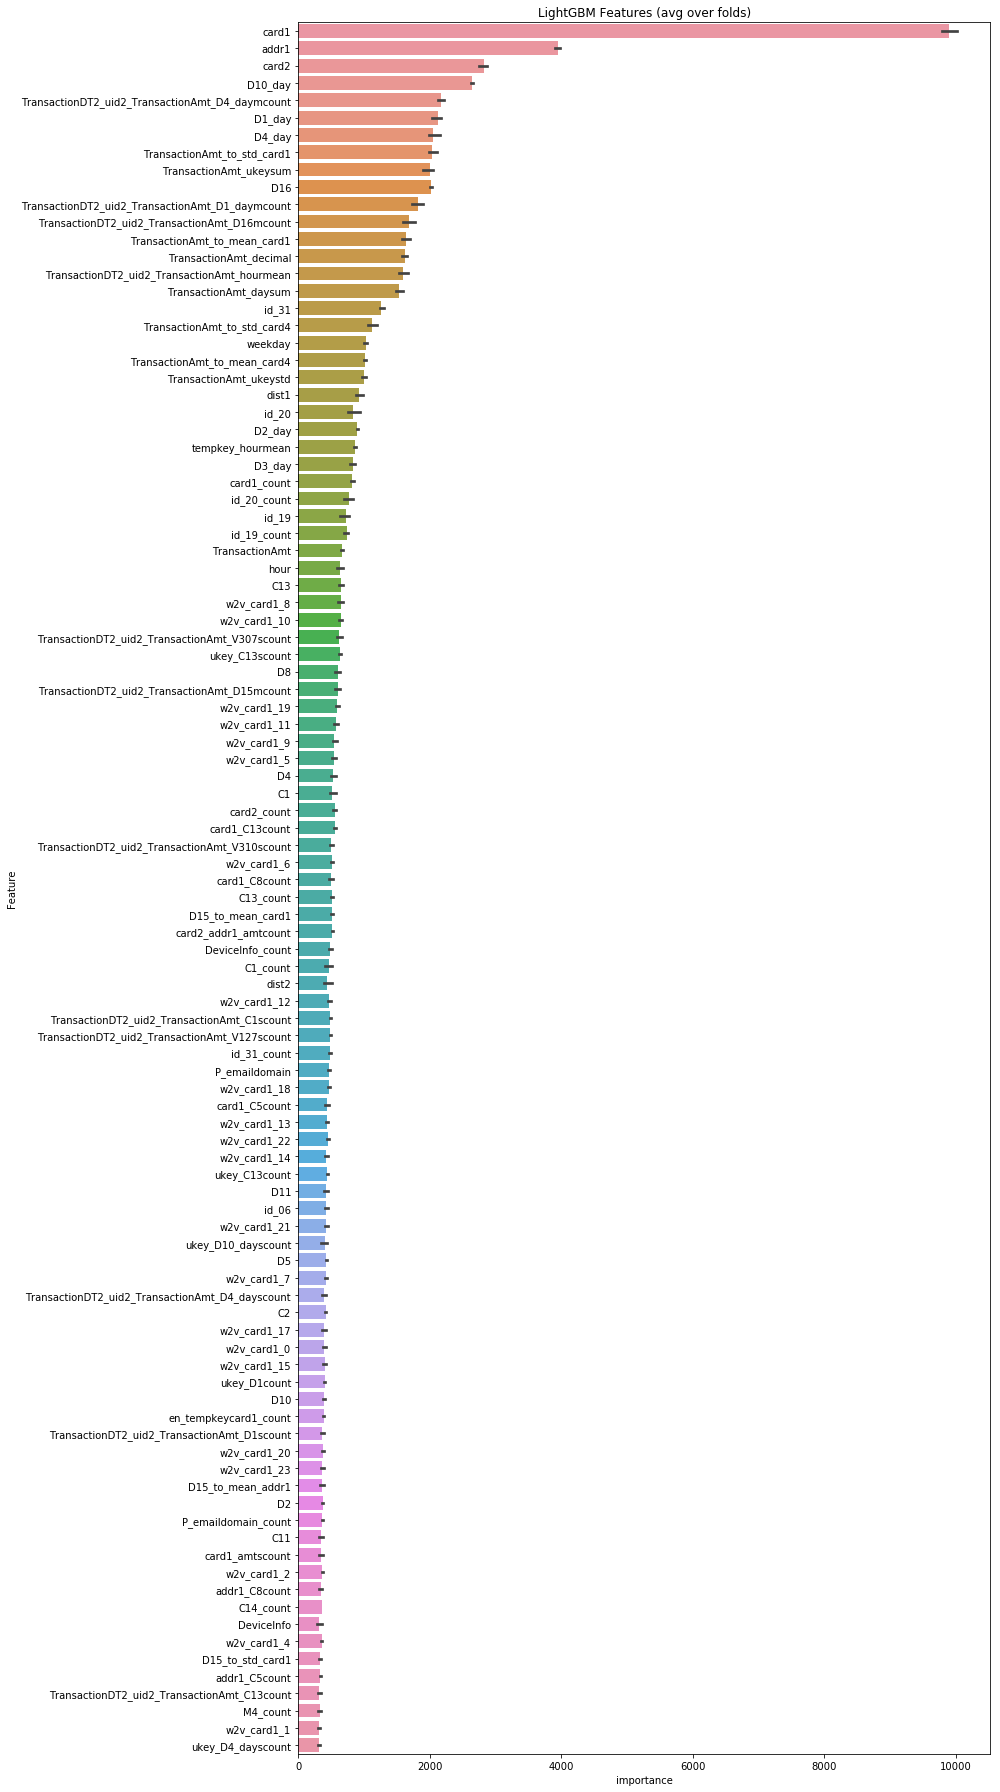

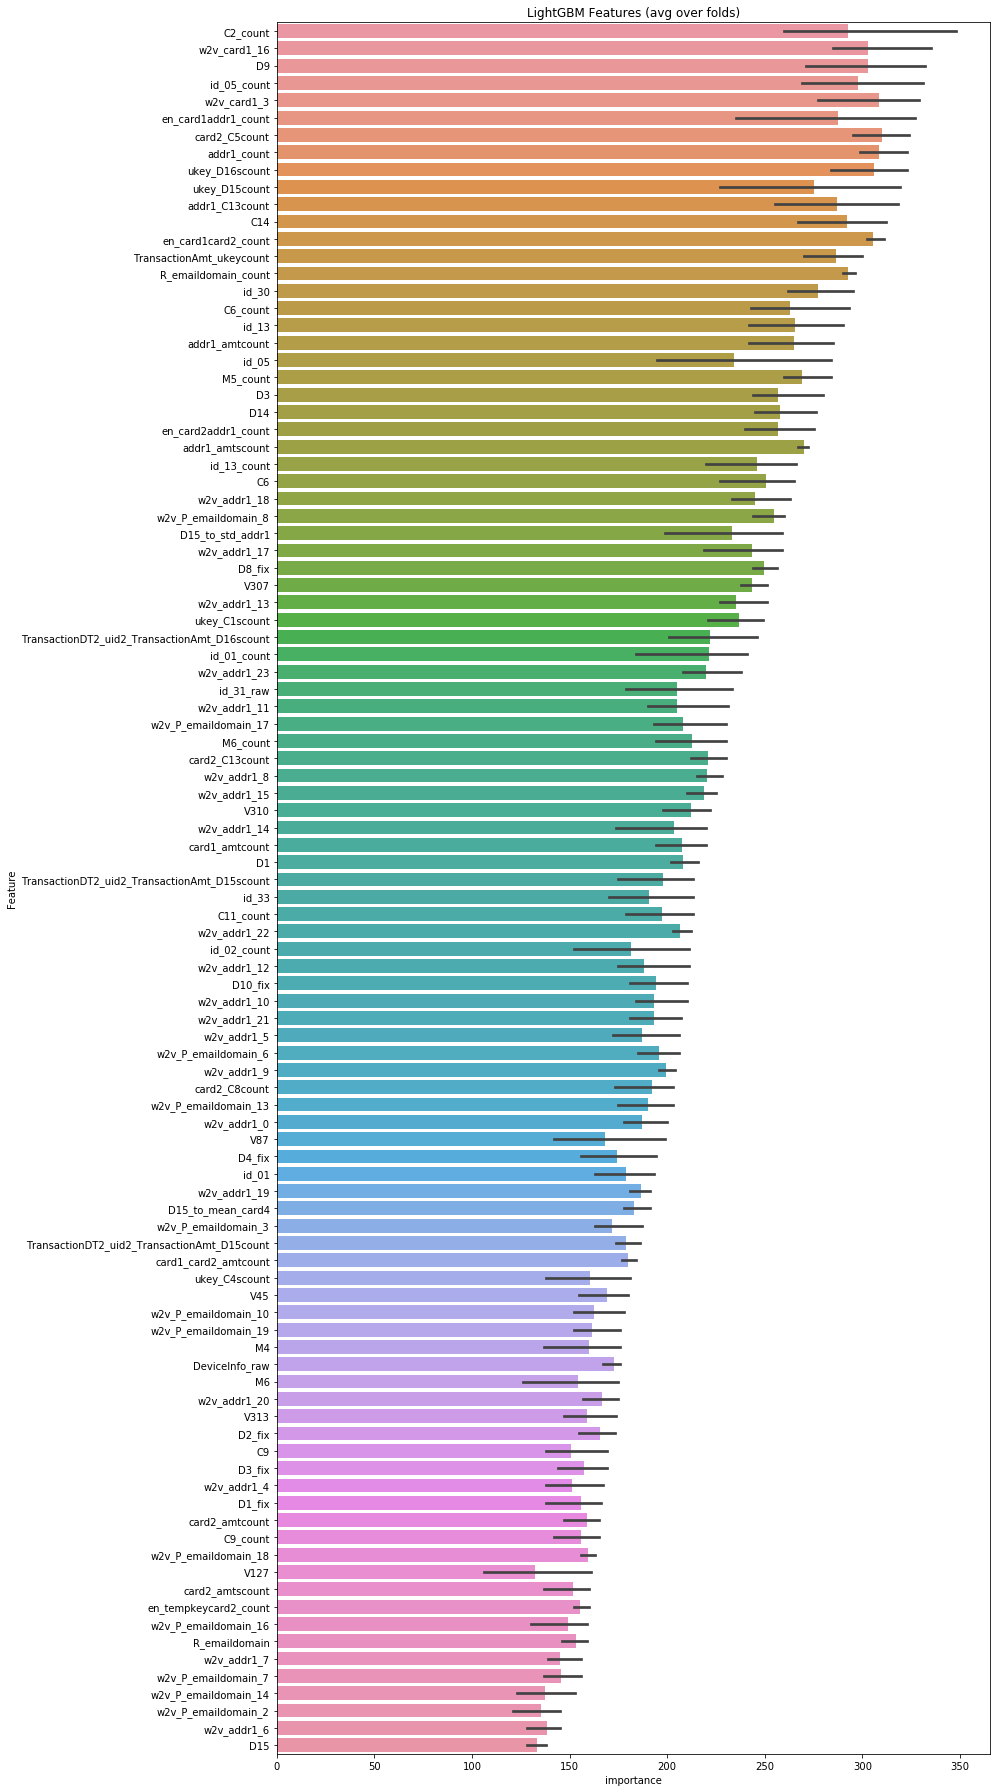

In [201]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[-100:].index)
print(cols)
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:100].index)
print(cols)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]
plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[100:200].index)
print(cols)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [202]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False).index)
for i in range(800):
    if cols[i].startswith("V"):
        print(i,cols[i])

130 V307
142 V310
172 V45
173 V87
181 V313
199 V127
207 V54
209 V317
210 V62
216 V264
221 V83
222 V38
224 V78
225 V165
226 V314
231 V130
233 V315
235 V44
236 V281
239 V75
241 V53
248 V82
250 V265
251 V86
252 V312
255 V308
259 V61
260 V221
261 V203
264 V13
267 V12
268 V76
269 V187
272 V261
273 V258
274 V266
275 V285
276 V20
280 V274
282 V67
283 V277
286 V37
287 V320
288 V263
289 V131
290 V311
291 V245
293 V294
295 V128
296 V47
297 V189
300 V283
301 V56
302 V36
303 V222
305 V77
306 V35
307 V55
310 V5
313 V243
315 V156
316 V267
317 V133
319 V19
321 V209
322 V276
324 V70
325 V149
326 V291
328 V306
329 V91
331 V229
333 V316
334 V204
336 V259
337 V202
338 V143
340 V49
341 V282
342 V275
343 V207
345 V126
346 V309
347 V99
350 V273
352 V208
354 V212
357 V152
358 V48
359 V217
360 V251
361 V52
362 V43
363 V40
364 V4
365 V29
366 V218
367 V64
368 V278
369 V60
370 V96
371 V139
373 V234
374 V332
376 V256
377 V268
378 V24
379 V129
380 V270
381 V30
384 V219
385 V170
386 V296
387 V90
388 V160
389 V323
3

IndexError: index 681 is out of bounds for axis 0 with size 681

In [ ]:
# import catboost as cb
# from catboost import CatBoostClassifier,Pool

# # os.environ['CUDA_VISIBLE_DEVICES'] = str(2)

# features = [x for x in X_train.columns if (x not in col_del ) and  not x.startswith("w2v")]
# print(len(features))
# cate = [x for x in features if (x == 'ProductCD' or x in ['card1','card2'] or  x.startswith("addr") or 
#                                        x.endswith("domain") or x.startswith("Device")) and not x.endswith("count") and not x == "id_11" 
#        ]

# # cate = []
# print(cate)
# verbose_eval = 30
# num_rounds = 700
# y_preds3_temp = np.zeros(X_test.shape[0])
# y_preds3_temp2 = np.zeros(X_test.shape[0])

# folds = 3
# kf = KFold(n_splits = folds, shuffle = True, random_state=seed+1)
# y_preds3 = np.zeros(X_test.shape[0])
# y_oof = np.zeros(X_train.shape[0])
# i = 0
# for tr_idx, val_idx in kf.split(X_train, y_train):

    
#     X_tr, X_vl = X_train[features].iloc[tr_idx, :].fillna(-999), X_train[features].iloc[val_idx, :].fillna(-999)
#     y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    
#     model=cb.CatBoostClassifier(iterations=num_rounds,depth=15,learning_rate=0.04,loss_function='Logloss',eval_metric='Logloss'
#                                 ,min_data_in_leaf=15,l2_leaf_reg=3.0
#                                 ,task_type = "GPU",devices = ["1"]
#                                )
#     if debug:
# #         model.fit(X_tr,y_tr,cat_features=cate,eval_set=(X_test[features].fillna(-999), y_test),verbose_eval = 30)
#         model.fit(X_tr,y_tr,cat_features=cate,verbose_eval = 30)
#     else:
# #         model.fit(X_tr,y_tr,cat_features=cate,eval_set=(X_vl[features], y_vl),verbose_eval = 30)
#         model.fit(X_tr,y_tr,cat_features=cate,verbose_eval = 30)
#     best_iter = model.get_best_iteration()
#     best_iter = 0
#     print(best_iter)
#     y_pred_train = model.predict_proba(X_vl,ntree_end = best_iter)[:,1]
#     y_oof[val_idx] = y_pred_train
#     print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
#     temp =  model.predict_proba(X_test[features].fillna(-999),ntree_end = best_iter)[:,1] 
#     y_preds3 += temp/ folds
    
    
#     if debug:    
#         print("debug:",roc_auc_score(y_test, temp),log_loss(y_test, temp))
#         best_iter = num_rounds - 100
#         y_preds3_temp += model.predict_proba(X_test[features].fillna(-999),ntree_end = best_iter)[:,1] / folds
#         best_iter = num_rounds - 200
#         y_preds3_temp2 += model.predict_proba(X_test[features].fillna(-999),ntree_end = best_iter)[:,1] / folds
#     i+=1

# if debug:    
#     print("debug:",roc_auc_score(y_test, y_preds3),log_loss(y_test, y_preds3))  
#     print("debug:",roc_auc_score(y_test, (y_preds + y_preds3)*0.5),log_loss(y_test, (y_preds + y_preds3)*0.5))  
#     print("debug:",roc_auc_score(y_test, (y_preds + y_preds2 + y_preds3)*0.33),log_loss(y_test, (y_preds + y_preds2 + y_preds3)*0.33))
#     print("debug:",roc_auc_score(y_test, (y_preds + y_preds2 + y_preds3*0.5)*0.33),log_loss(y_test, (y_preds + y_preds2 + y_preds3*0.5)*0.33))
#     print("debug:",roc_auc_score(y_test, (y_preds + y_preds2 + y_preds3_temp*0.5)*0.33),log_loss(y_test, (y_preds + y_preds2 + y_preds3_temp*0.5)*0.33))
#     print("debug:",roc_auc_score(y_test, (y_preds + y_preds2 + y_preds3_temp2*0.5)*0.33),log_loss(y_test, (y_preds + y_preds2 + y_preds3_temp2*0.5)*0.33))

In [ ]:

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds),log_loss(y_test, y_preds))  
    print("debug:",roc_auc_score(y_test, y_preds2),log_loss(y_test, y_preds2))  
    print("debug:",roc_auc_score(y_test, y_preds3),log_loss(y_test, y_preds3))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds3)*0.5),log_loss(y_test, (y_preds + y_preds3)*0.5))
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2 + y_preds3)*0.33),log_loss(y_test, (y_preds + y_preds2 + y_preds3)*0.33))
    print("debug:",roc_auc_score(y_test, (y_preds11*0.4 + y_preds*0.6 + y_preds2 + y_preds3*0.5)/2.5),log_loss(y_test, (y_preds11*0.4 + y_preds*0.6 + y_preds2 + y_preds3*0.5)/2.5))
    print("debug:",roc_auc_score(y_test, (y_preds11*0.4 + y_preds*0.6 + y_preds2 + y_preds22*0.5 + y_preds3*0.5)/3.0),log_loss(y_test, (y_preds11*0.4 + y_preds*0.6 + y_preds2 + y_preds22*0.5 + y_preds3*0.5)/3.0))


In [ ]:

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds),log_loss(y_test, y_preds))  
    print("debug:",roc_auc_score(y_test, y_preds2),log_loss(y_test, y_preds2))  
    print("debug:",roc_auc_score(y_test, y_preds3),log_loss(y_test, y_preds3))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds3)*0.5),log_loss(y_test, (y_preds + y_preds3)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2 + y_preds3)*0.33),log_loss(y_test, (y_preds + y_preds2 + y_preds3)*0.33))
    print("debug:",roc_auc_score(y_test, (y_preds11*0.4 + y_preds*0.6 + y_preds2 + y_preds3*0.5)*0.33),log_loss(y_test, (y_preds11*0.4 + y_preds*0.6 + y_preds2 + y_preds3*0.5)*0.33))
    print("debug:",roc_auc_score(y_test, (y_preds11*1.0 + y_preds*1.0 + y_preds2 + y_preds22*0.5 + y_preds3*0.5)*0.33),log_loss(y_test, (y_preds11*1.0 + y_preds*1.0 + y_preds2 + y_preds22*0.5 + y_preds3*0.5)/4))
    

In [ ]:
if debug:
    X_test_pred = pd.DataFrame(index = X_test.index)
    X_test_pred['y_pred'] = y_preds
    X_test_pred['y_pred11'] = y_preds11
    X_test_pred['y_preds2'] = y_preds2
    X_test_pred['y_preds22'] = y_preds22
    X_test_pred['pred'] = (y_preds + y_preds11 + y_preds12 * 0.5 + y_preds2 + y_preds22*0.5)/4
    X_test_pred['true'] = y_test
    X_test_pred.to_csv('simple_offline28.csv')
else:
#     sample_submission['isFraud'] =  (y_preds11*0.5 + y_preds*0.5 + y_preds2 + y_preds3*0.5)/2.5
    sample_submission['isFraud'] =  np.array(mean_np)
    sample_submission.to_csv('simple_ensemble28.csv')
